# Geomechanical Earth Modeling with Measured While Drilling Data using Machine Learning Algorithms
___
- **Author:** Badr Eddine Berrehal (*Petroleum Engineer & Data Analyst*)
- **Email:** [berrehalbadr@gmail.com](berrehalbadr@gmail.com)
- **LinkedIn:** [Badr Berrehal](https://www.linkedin.com/in/badreddine-berrehal-a51010175)
- **Personal Web site:** [UDATA](https://sites.google.com/view/badreddine-berrehal/accueil)
- **GitHub:** [berrehalbadr](https://github.com/berrehalbadr)
- **License Type:** MIT license
___
## a. Project Overview
Geomechanical models are a crucial part of **reservoir modeling** and simulation as they allow the identification of parameters quantifying the behavior of the formation in the face of different stimuli such as stress, a vital concept in the drilling process when it comes to applying drilling parameters to **maximize advancement** and **minimize Non-Productive Time** due to unexpected events. 

Despite its usefulness, the execution of the latter relies on a number of operations that are not only **expensive** but also **time consuming**, e.g., **core sampling** and **laboratory analysis**, various **well logs**, **well tests**, etc. 

The final GEM would allow the user to mitigate well stability issues, prevent production breakdown, optimize the overall production rate of the well. And many other critical utilities.

## b. Project Objective
The main objective of this study is to investigate the underlying **relationship** between the data **measured while drilling** and the **geomechanical parameters**, and thus to create a model that would allow an accurate prediction of the parameters from the latter data in **real time**, or at least to have a very accurate estimate, especially when combined with other geological and seismic acquisition data.

## c. Data Utilized
The data used in this study were assembled from an extensive treatment of the open source **Volve field** in Norway published by **EQUINOR** in 2018. The main pre-processing steps before obtaining the final data for the model include, but are not limited to:  
* Extraction of drilling data from daily drilling reports.
* Digitizing the scanned well logs.
* Completion and completion reports.
* Geological survivals.

## d. Disclaimer
The project developed here is valid in the context of the data on which it was trained, deployment in the field requires further optimization according to the situation.

# 1. Importing Libs and Data

In [2]:
# Computation and vis
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lasio
import missingno as msno
from sklearn import ensemble
from sklearn.metrics import r2_score

# Sys
import glob
import itertools
import os

# Data treatment
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import LabelEncoder

# Predictive models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor

# Model tuning
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Visualization libreries
from tools_set.visuals import Data_couvrage, Multi_hist, Multi_boxplot, Multi_crossplot, Triple_angle_3D, Log_vis
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
init_notebook_mode(connected=True)
# For offline use
cf.go_offline()

# Statistics
from scipy import stats

import warnings

np.random.seed(0)
warnings.filterwarnings('ignore')

In [8]:
# Read the Files
Csv_file_list = []
path = './Logs_Geomechanics_drill_data/'
# View contents of the path
files = os.listdir(path)

In [9]:
files=[ '15_9-19_SR_STAT1990__30-1__15-9-19_SR__COMPOSITE__1.csv',
 '15_9-F-1 A_15_9-F1 A Curves.csv',
 '15_9-F-1 B_15_9-F1 B Curves.csv',
 '15_9-F-1 C_15_9-F1 C Curves.csv',
 '15_9-F-10_CPI_INPUT_logdata_0.csv',
 '15_9-F-11 A_15_9-F11 A Curves.csv',
 '15_9-F-11 B_15_9-F11 B Curves.csv',
 '15_9-F-11 T2_15_9-F11 T2 Curves.csv',
 '15_9-F-12_15_9-F12 Curves.csv',
 '15_9-F-14_INPUT_logdata_0.csv',
 '15_9-F-15 A_CPI_INPUT_logdata_0.csv',
 '15_9-F-15 B_CPI_INPUT_logdata_0.csv',
 '15_9-F-15 C_CPI_INPUT_logdata_0.csv',
 '15_9-F-15 D_15_9-F15 D Curves.csv',
 '15_9-F-15_CPI_INPUT_logdata_0.csv',
 '15_9-F-1_15_9-F1 Curves.csv',
 '15_9-F-4_INPUT_logdata_0.csv',
 '15_9-F-5_INPUT_logdata_0.csv']

Csv_file_list=[]
for file in files:
    if file.lower().endswith('.csv'):
        Csv_file_list.append(path + file)

In [6]:
# Create two data set one as a seperate list
# The second is a concatenated version
df_list=[]
for file in Csv_file_list:
    df = pd.read_csv(file, index_col=None)
    df.reset_index(inplace=True)
    df_list.append(df)
    
well1, well2, well3, well4= df_list

# 2. Exploratory Data Analysis

Let's take a look at some examples of the available data within a couple of wells.

In [7]:
for i in range(len(Csv_file_list)):
        print(f'''Example of the dataset {files[i][:-4]}''')
        display(df_list[i].describe())
        display(df_list[i].head())
        display(df_list[i].info())
        print('\n')

Example of the dataset 15_9-F-14_Geo_drill_data


index         DEPTH  Average Fracture pressure  \
count  23474.000000  23474.000000               16260.000000   
mean   11736.500000   1961.159400                   1.768360   
std     6776.504446   1032.739277                   0.060003   
min        0.000000    172.516800                   1.638349   
25%     5868.250000   1066.838100                   1.722115   
50%    11736.500000   1961.159400                   1.778213   
75%    17604.750000   2855.480700                   1.820452   
max    23473.000000   3749.802000                   1.854339   

       Average Hookload kkgf  Average Pore pressure  Average Rotary Speed rpm  \
count           16260.000000           16260.000000              16260.000000   
mean              133.526262               1.010663                137.406235   
std                13.214807               0.025521                 35.596946   
min                87.216326               0.955365                 24.530001   
25%               129.605929               0.990993                119.790001   
50%               138.375487               1.014854                159.229996   
75%               140.914586               1.032819                160.360001   
max               152.926842               1.047233                181.550003   

       Average Standpipe Pressure kPa  Average Surface Torque kN_m  \
count                    16260.000000                 16260.000000   
mean                     17331.169841                    11.211654   
std                       3195.543188                     2.648486   
min                       4509.000018                     1.610000   
25%                      15321.646305                     9.449638   
50%                      17441.999820                    11.330000   
75%                      18725.749970                    12.850001   
max                      24907.000730                    26.550000   

               Azim        Azim_2  ...           TVD        TVDBML  \
count  23114.000000  16262.000000  ...  23114.000000  23114.000000   
mean     110.278822    120.379303  ...   1850.948811   1614.048811   
std       72.544695     80.318657  ...    907.788288    907.788288   
min        0.294791      0.094857  ...    172.516672    -64.383328   
25%       56.899420     55.564108  ...   1052.679585    815.779585   
50%       85.500235     85.594320  ...   1933.279901   1696.379901   
75%      164.267900    185.470675  ...   2751.685308   2514.785308   
max      359.809500    359.234100  ...   3123.367239   2886.467239   

              TVDSS        tvdTop          UCS  USROP Gamma gAPI  \
count  23114.000000  18818.000000  6967.000000      16260.000000   
mean    1705.048811   2004.330556    74.907079         65.612625   
std      907.788288    811.032375    33.205158         37.009748   
min       26.616672    881.500000     3.092914          0.000000   
25%      906.779585   1206.500000    65.666590         37.614552   
50%     1787.379901   2267.500000    74.962910         64.056760   
75%     2605.785308   2862.300000    91.220390         94.433000   
max     2977.467239   3113.800000   248.440900        260.899000   

       Weight on Bit kkgf      YME_DYN      YME_STA             Z  
count        16260.000000  6126.000000  6126.000000  23114.000000  
mean             5.658819     3.844036    19.877772  -1705.048811  
std              2.454283     1.039025     5.372871    907.788288  
min              0.469069     2.227479    11.518450  -2977.467239  
25%              4.242019     3.176454    16.425655  -2605.785308  
50%              5.424890     3.546763    18.340555  -1787.379901  
75%              6.556775     4.297238    22.221305   -906.779585  
max             15.091800    11.325890    58.566930    -26.616672  

[8 rows x 64 columns]

index   wellName     datasetName     DEPTH  Average Fracture pressure  \
0      0  15/9-F-14  Geo_drill_data  172.5168                        NaN   
1      1  15/9-F-14  Geo_drill_data  172.6692                        NaN   
2      2  15/9-F-14  Geo_drill_data  172.8216                        NaN   
3      3  15/9-F-14  Geo_drill_data  172.9740                        NaN   
4      4  15/9-F-14  Geo_drill_data  173.1264                        NaN   

   Average Hookload kkgf  Average Pore pressure  Average Rotary Speed rpm  \
0                    NaN                    NaN                       NaN   
1                    NaN                    NaN                       NaN   
2                    NaN                    NaN                       NaN   
3                    NaN                    NaN                       NaN   
4                    NaN                    NaN                       NaN   

   Average Standpipe Pressure kPa  Average Surface Torque kN_m  ...  \
0                             NaN                          NaN  ...   
1                             NaN                          NaN  ...   
2                             NaN                          NaN  ...   
3                             NaN                          NaN  ...   
4                             NaN                          NaN  ...   

      TVDBML      TVDSS  tvdTop UCS  USROP Gamma gAPI  Weight on Bit kkgf  \
0 -64.383328  26.616672     NaN NaN               NaN                 NaN   
1 -64.230930  26.769070     NaN NaN               NaN                 NaN   
2 -64.078531  26.921469     NaN NaN               NaN                 NaN   
3 -63.926132  27.073868     NaN NaN               NaN                 NaN   
4 -63.773733  27.226267     NaN NaN               NaN                 NaN   

  YME_DYN  YME_STA          Z  Zone Name  
0     NaN      NaN -26.616672        NaN  
1     NaN      NaN -26.769070        NaN  
2     NaN      NaN -26.921469        NaN  
3     NaN      NaN -27.073868        NaN  
4     NaN      NaN -27.226267        NaN  

[5 rows x 72 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23474 entries, 0 to 23473
Data columns (total 72 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           23474 non-null  int64  
 1   wellName                        23474 non-null  object 
 2   datasetName                     23474 non-null  object 
 3   DEPTH                           23474 non-null  float64
 4   Average Fracture pressure       16260 non-null  float64
 5   Average Hookload kkgf           16260 non-null  float64
 6   Average Pore pressure           16260 non-null  float64
 7   Average Rotary Speed rpm        16260 non-null  float64
 8   Average Standpipe Pressure kPa  16260 non-null  float64
 9   Average Surface Torque kN_m     16260 non-null  float64
 10  Azim                            23114 non-null  float64
 11  Azim_2                          16262 non-null  float64
 12  AZIM_TN                         

None



Example of the dataset 15_9-F-15 A_Geo_drill_data


index         DEPTH  Average Fracture pressure  \
count  25389.000000  25389.000000               17622.000000   
mean   12694.000000   2151.430800                   1.826333   
std     7329.317328   1116.987961                   0.057039   
min        0.000000    216.865200                   1.706930   
25%     6347.000000   1184.148000                   1.781256   
50%    12694.000000   2151.430800                   1.834528   
75%    19041.000000   3118.713600                   1.876080   
max    25388.000000   4085.996400                   1.910148   

       Average Hookload kkgf  Average Pore pressure  Average Rotary Speed rpm  \
count           17622.000000           17622.000000              17622.000000   
mean              132.667994               1.055387                177.107187   
std                 7.520938               0.029541                 58.893708   
min                84.047945               0.993547                 13.330170   
25%               126.893488               1.032041                119.986650   
50%               132.521936               1.059631                179.000000   
75%               139.362191               1.081152                248.064275   
max               151.620090               1.098796                290.496000   

       Average Standpipe Pressure kPa  Average Surface Torque kN_m  \
count                    17622.000000                 17622.000000   
mean                     20434.391262                    14.136079   
std                       3451.969472                     2.732122   
min                       1512.505965                     0.008259   
25%                      17697.956428                    11.920000   
50%                      21338.411700                    14.110000   
75%                      23053.201910                    16.587130   
max                      24998.045730                    24.228467   

               Azim        Azim_2  ...          TVD        TVDBML  \
count  25389.000000  17623.000000  ...    80.000000  25389.000000   
mean     218.050029    231.635097  ...  1752.367500   1691.173691   
std       53.078820     53.947749  ...   883.082055    885.523013   
min      124.070000    143.100400  ...   262.500000    -20.035078   
25%      173.355800    179.867350  ...   976.975000    929.111987   
50%      217.154900    249.813300  ...  1798.300000   1812.879685   
75%      269.083300    280.074150  ...  2492.850000   2549.572828   
max      298.080000    298.080000  ...  3184.800000   2968.366984   

              TVDSS        tvdTop          UCS  USROP Gamma gAPI  \
count  25389.000000  12343.000000  9369.000000      17622.000000   
mean    1782.173691   2666.678263    86.803719         60.865181   
std      885.523013    294.787340    29.971266         48.163599   
min       70.964922   2099.500000    14.385390          0.000000   
25%     1020.111987   2453.300000    62.279980         18.674965   
50%     1903.879685   2645.000000    88.244940         52.260000   
75%     2640.572828   2902.000000   108.991200         95.510000   
max     3059.366984   3127.500000   197.675000        255.462000   

       Weight on Bit kkgf      YME_DYN      YME_STA             Z  
count        17622.000000  9369.000000  9369.000000  25389.000000  
mean             6.125613     5.404141    27.945179  -1782.173691  
std              4.160493     1.579410     8.167237    885.523013  
min              0.004777     1.814313     9.381937  -3059.366984  
25%              3.359435     4.144782    21.432950  -2640.572828  
50%              4.853849     5.502034    28.451400  -1903.879685  
75%              7.596886     6.576967    34.009940  -1020.111987  
max             31.411272    11.260010    58.226290    -70.964922  

[8 rows x 69 columns]

index     wellName     datasetName     DEPTH  Average Fracture pressure  \
0      0  15/9-F-15 A  Geo_drill_data  216.8652                        NaN   
1      1  15/9-F-15 A  Geo_drill_data  217.0176                        NaN   
2      2  15/9-F-15 A  Geo_drill_data  217.1700                        NaN   
3      3  15/9-F-15 A  Geo_drill_data  217.3224                        NaN   
4      4  15/9-F-15 A  Geo_drill_data  217.4748                        NaN   

   Average Hookload kkgf  Average Pore pressure  Average Rotary Speed rpm  \
0                    NaN                    NaN                       NaN   
1                    NaN                    NaN                       NaN   
2                    NaN                    NaN                       NaN   
3                    NaN                    NaN                       NaN   
4                    NaN                    NaN                       NaN   

   Average Standpipe Pressure kPa  Average Surface Torque kN_m  ...  \
0                             NaN                          NaN  ...   
1                             NaN                          NaN  ...   
2                             NaN                          NaN  ...   
3                             NaN                          NaN  ...   
4                             NaN                          NaN  ...   

      TVDBML      TVDSS  tvdTop UCS  USROP Gamma gAPI  Weight on Bit kkgf  \
0 -20.035078  70.964922     NaN NaN               NaN                 NaN   
1 -19.882679  71.117321     NaN NaN               NaN                 NaN   
2 -19.730280  71.269720     NaN NaN               NaN                 NaN   
3 -19.577882  71.422118     NaN NaN               NaN                 NaN   
4 -19.425483  71.574517     NaN NaN               NaN                 NaN   

   YME_DYN YME_STA          Z  Zone Name  
0      NaN     NaN -70.964922        NaN  
1      NaN     NaN -71.117321        NaN  
2      NaN     NaN -71.269720        NaN  
3      NaN     NaN -71.422118        NaN  
4      NaN     NaN -71.574517        NaN  

[5 rows x 77 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25389 entries, 0 to 25388
Data columns (total 77 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           25389 non-null  int64  
 1   wellName                        25389 non-null  object 
 2   datasetName                     25389 non-null  object 
 3   DEPTH                           25389 non-null  float64
 4   Average Fracture pressure       17622 non-null  float64
 5   Average Hookload kkgf           17622 non-null  float64
 6   Average Pore pressure           17622 non-null  float64
 7   Average Rotary Speed rpm        17622 non-null  float64
 8   Average Standpipe Pressure kPa  17622 non-null  float64
 9   Average Surface Torque kN_m     17622 non-null  float64
 10  Azim                            25389 non-null  float64
 11  Azim_2                          17623 non-null  float64
 12  AZIM_TN                         

None



Example of the dataset 15_9-F-15_Geo_drill_data


index         DEPTH  Average Fracture pressure  \
count  26838.000000  26838.000000               18103.000000   
mean   13418.500000   2044.979400                   1.848318   
std     7747.607598   1180.735398                   0.049004   
min        0.000000      0.000000                   1.706929   
25%     6709.250000   1022.489700                   1.828701   
50%    13418.500000   2044.979400                   1.847972   
75%    20127.750000   3067.469100                   1.893545   
max    26837.000000   4089.958800                   1.912362   

       Average Hookload kkgf  Average Pore pressure  Average Rotary Speed rpm  \
count           18103.000000           18103.000000              18103.000000   
mean              132.378352               1.066773                133.100446   
std                 6.596873               0.025380                 16.368152   
min               114.845489               0.993546                 29.000000   
25%               127.384784               1.056613                129.720000   
50%               130.203690               1.066594                139.736000   
75%               136.525747               1.090197                139.736000   
max               149.742635               1.099943                140.306700   

       Average Standpipe Pressure kPa  Average Surface Torque kN_m  \
count                    18103.000000                 18103.000000   
mean                     18538.933773                    19.553479   
std                       4507.265964                     7.139373   
min                       4363.622943                     2.167391   
25%                      14756.049240                    12.888539   
50%                      16121.107070                    18.429458   
75%                      23507.890105                    26.510308   
max                      24993.012550                    36.476945   

               Azim        Azim_2  ...        TVDBML         TVDSS  \
count  25881.000000  18104.000000  ...  26838.000000  26838.000000   
mean     203.117248    211.623103  ...   1567.325142   1658.325145   
std       26.874867     13.379196  ...    929.277414    929.277413   
min     -103.324000    197.671600  ...   -236.900000   -145.900000   
25%      200.936600    202.288250  ...    774.414350    865.414350   
50%      203.974100    205.794400  ...   1700.471500   1791.471500   
75%      214.180300    214.379000  ...   2418.671500   2509.671500   
max      253.690000    243.199500  ...   2932.987000   3023.987000   

             tvdTop           UCS   UCS_McNally  USROP Gamma gAPI  \
count  21272.000000  10016.000000  10016.000000      18103.000000   
mean    1150.832691     83.789777     83.789777         79.732045   
std       89.368138     42.761548     42.761548         53.236311   
min      842.400000     10.236200     10.236200          0.000000   
25%     1179.400000     46.762390     46.762390         34.955400   
50%     1179.400000     86.366140     86.366140         60.977170   
75%     1179.400000    119.555550    119.555550        129.771250   
max     1179.400000    182.800000    182.800000        256.164000   

       Weight on Bit kkgf       YME_DYN       YME_STA             Z  
count        18103.000000  10016.000000  10016.000000  26838.000000  
mean             6.393364      5.297847     27.395527  -1658.325145  
std              4.230462      2.217170     11.465139    929.277413  
min              0.004536      1.337270      6.915116  -3023.987000  
25%              2.537722      3.310019     17.116335  -2509.671500  
50%              5.897709      5.404404     27.946540  -1791.471500  
75%              8.854102      7.119798     36.816960   -865.414350  
max             19.830882     10.706140     55.362170    145.900000  

[8 rows x 71 columns]

index   wellName     datasetName   DEPTH  Average Fracture pressure  \
0      0  15/9-F-15  Geo_drill_data  0.0000                        NaN   
1      1  15/9-F-15  Geo_drill_data  0.1524                        NaN   
2      2  15/9-F-15  Geo_drill_data  0.3048                        NaN   
3      3  15/9-F-15  Geo_drill_data  0.4572                        NaN   
4      4  15/9-F-15  Geo_drill_data  0.6096                        NaN   

   Average Hookload kkgf  Average Pore pressure  Average Rotary Speed rpm  \
0                    NaN                    NaN                       NaN   
1                    NaN                    NaN                       NaN   
2                    NaN                    NaN                       NaN   
3                    NaN                    NaN                       NaN   
4                    NaN                    NaN                       NaN   

   Average Standpipe Pressure kPa  Average Surface Torque kN_m  ...     TVDSS  \
0                             NaN                          NaN  ... -145.9000   
1                             NaN                          NaN  ... -145.7476   
2                             NaN                          NaN  ... -145.5952   
3                             NaN                          NaN  ... -145.4428   
4                             NaN                          NaN  ... -145.2904   

   tvdTop  UCS UCS_McNally  USROP Gamma gAPI  Weight on Bit kkgf  YME_DYN  \
0     NaN  NaN         NaN               NaN                 NaN      NaN   
1     NaN  NaN         NaN               NaN                 NaN      NaN   
2     NaN  NaN         NaN               NaN                 NaN      NaN   
3     NaN  NaN         NaN               NaN                 NaN      NaN   
4     NaN  NaN         NaN               NaN                 NaN      NaN   

  YME_STA         Z  Zone Name  
0     NaN  145.9000        NaN  
1     NaN  145.7476        NaN  
2     NaN  145.5952        NaN  
3     NaN  145.4428        NaN  
4     NaN  145.2904        NaN  

[5 rows x 79 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26838 entries, 0 to 26837
Data columns (total 79 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           26838 non-null  int64  
 1   wellName                        26838 non-null  object 
 2   datasetName                     26838 non-null  object 
 3   DEPTH                           26838 non-null  float64
 4   Average Fracture pressure       18103 non-null  float64
 5   Average Hookload kkgf           18103 non-null  float64
 6   Average Pore pressure           18103 non-null  float64
 7   Average Rotary Speed rpm        18103 non-null  float64
 8   Average Standpipe Pressure kPa  18103 non-null  float64
 9   Average Surface Torque kN_m     18103 non-null  float64
 10  Azim                            25881 non-null  float64
 11  Azim_2                          18104 non-null  float64
 12  AZIM_TN                         

None



Example of the dataset 15_9-F-5_Geo_drill_data


index         DEPTH  Average Fracture pressure  \
count  22120.000000  22120.000000                6326.000000   
mean   11059.500000   2106.701400                   1.772720   
std     6385.638313    973.171279                   0.027833   
min        0.000000    421.233600                   1.724524   
25%     5529.750000   1263.967500                   1.748622   
50%    11059.500000   2106.701400                   1.772720   
75%    16589.250000   2949.435300                   1.796819   
max    22119.000000   3792.169200                   1.820917   

       Average Hookload kkgf  Average Pore pressure  Average Rotary Speed rpm  \
count            6326.000000            6326.000000               6326.000000   
mean              137.051162               1.098912                189.843646   
std                 5.642639               0.016700                 78.568844   
min               114.055257               1.069994                 24.160000   
25%               132.216408               1.084453                129.949997   
50%               135.448906               1.098912                179.960007   
75%               142.943811               1.113371                281.929993   
max               148.378901               1.127830                311.230011   

       Average Standpipe Pressure kPa  Average Surface Torque kN_m  \
count                     6326.000000                  6326.000000   
mean                     21545.825925                    23.913414   
std                       2466.638420                     3.992927   
min                       9781.999969                     5.570000   
25%                      20910.000610                    21.900000   
50%                      21275.999450                    24.102199   
75%                      23267.589285                    27.100001   
max                      24997.000120                    30.880000   

               Azim       Azim_2  ...          TVD        TVDBML  \
count  22106.000000  6326.000000  ...    79.000000  22104.000000   
mean      91.842236    37.636618  ...  1902.648101   1670.572063   
std       40.770752    19.670112  ...   836.327089    821.039374   
min       16.570000    16.582070  ...   462.200000    183.784111   
25%       72.835022    22.229940  ...  1189.450000    979.249819   
50%      103.945350    28.201490  ...  1931.400000   1681.178739   
75%      114.104200    51.030175  ...  2609.900000   2394.034841   
max      180.100000    80.779690  ...  3246.100000   3008.161050   

              TVDSS       tvdTop          UCS  USROP Gamma gAPI  \
count  22104.000000  9775.000000  5566.000000       6326.000000   
mean    1761.572063  2640.531437    85.033144         40.585916   
std      821.039374   363.201831    35.472692         39.757710   
min      274.784111  2033.500000    13.143140          0.000000   
25%     1070.249819  2342.000000    56.343730         12.960835   
50%     1772.178739  2615.300000    80.570450         26.431000   
75%     2485.034841  2926.000000   113.447150         48.670000   
max     3099.161050  3198.900000   211.065000        260.060000   

       Weight on Bit kkgf      YME_DYN      YME_STA             Z  
count         6326.000000  5566.000000  5566.000000  22104.000000  
mean             7.270055     5.355964    27.696054  -1761.572063  
std              3.319421     1.851047     9.571892    821.039374  
min              0.010197     1.719580     8.892063  -3099.161050  
25%              4.966018     3.723977    19.256943  -2485.034841  
50%              6.964662     5.158297    26.673900  -1772.178739  
75%              9.118928     6.804151    35.184720  -1070.249819  
max             14.847068    12.268500    63.441250   -274.784111  

[8 rows x 66 columns]

index  wellName     datasetName     DEPTH  Average Fracture pressure  \
0      0  15/9-F-5  Geo_drill_data  421.2336                        NaN   
1      1  15/9-F-5  Geo_drill_data  421.3860                        NaN   
2      2  15/9-F-5  Geo_drill_data  421.5384                        NaN   
3      3  15/9-F-5  Geo_drill_data  421.6908                        NaN   
4      4  15/9-F-5  Geo_drill_data  421.8432                        NaN   

   Average Hookload kkgf  Average Pore pressure  Average Rotary Speed rpm  \
0                    NaN                    NaN                       NaN   
1                    NaN                    NaN                       NaN   
2                    NaN                    NaN                       NaN   
3                    NaN                    NaN                       NaN   
4                    NaN                    NaN                       NaN   

   Average Standpipe Pressure kPa  Average Surface Torque kN_m  ...  \
0                             NaN                          NaN  ...   
1                             NaN                          NaN  ...   
2                             NaN                          NaN  ...   
3                             NaN                          NaN  ...   
4                             NaN                          NaN  ...   

       TVDBML       TVDSS  tvdTop UCS  USROP Gamma gAPI  Weight on Bit kkgf  \
0  183.784111  274.784111     NaN NaN               NaN                 NaN   
1  183.934826  274.934826     NaN NaN               NaN                 NaN   
2  184.085540  275.085540     NaN NaN               NaN                 NaN   
3  184.236251  275.236251     NaN NaN               NaN                 NaN   
4  184.386960  275.386960     NaN NaN               NaN                 NaN   

   YME_DYN  YME_STA           Z  Zone Name  
0      NaN      NaN -274.784111        NaN  
1      NaN      NaN -274.934826        NaN  
2      NaN      NaN -275.085540        NaN  
3      NaN      NaN -275.236251        NaN  
4      NaN      NaN -275.386960        NaN  

[5 rows x 73 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22120 entries, 0 to 22119
Data columns (total 73 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           22120 non-null  int64  
 1   wellName                        22120 non-null  object 
 2   datasetName                     22120 non-null  object 
 3   DEPTH                           22120 non-null  float64
 4   Average Fracture pressure       6326 non-null   float64
 5   Average Hookload kkgf           6326 non-null   float64
 6   Average Pore pressure           6326 non-null   float64
 7   Average Rotary Speed rpm        6326 non-null   float64
 8   Average Standpipe Pressure kPa  6326 non-null   float64
 9   Average Surface Torque kN_m     6326 non-null   float64
 10  Azim                            22106 non-null  float64
 11  Azim_2                          6326 non-null   float64
 12  AZIM_TN                         

None

Some wells include more than **72 parameters** that are mostly **drilling related**, there seem to be some **outliers** in some parameters, which can be deduced from the min and max as well as the mean, but we still need to visualize them to be sure.

Next, let's take a quick look at the **commonality columns** between some of the wells, if there are any **inconsistencies** in the data we will need to **normalize** the indicators across the wells at least for the most important ones.

In [8]:
# Find the commune columns in the data
CC= well1.columns & well2.columns & well3.columns & well4.columns
CC

Index(['index', 'wellName', 'datasetName', 'DEPTH',
       'Average Fracture pressure', 'Average Hookload kkgf',
       'Average Pore pressure', 'Average Rotary Speed rpm',
       'Average Standpipe Pressure kPa', 'Average Surface Torque kN_m', 'Azim',
       'Azim_2', 'AZIM_TN', 'Bit type', 'BMK_DYN', 'D_exp', 'DEN_COM_EXT',
       'DEN_EXTRAPOLATE', 'Diameter mm', 'DRHO', 'DT', 'DTS', 'DX_TN', 'DY_TN',
       'FANG', 'Formation', 'Fracture pressure', 'GR', 'Inc', 'Inc_2', 'INCL',
       'MD', 'MECH_LITHO', 'MECH_STRATIGRAPHY', 'Mud Density In g/cm3',
       'Mud Flow In L/min', 'Mud type', 'MW', 'NPHI', 'OBMW_EXT', 'P',
       'Pore pressure (s_g_)', 'PPMW_HP_D', 'PPMW_NORM', 'PPRS_HP_D',
       'PPRS_NORM', 'PR_DYN', 'PR_STA', 'Rate of Penetration m/h', 'RD',
       'RHOB', 'RS', 'RT', 'SHMAX_PHS', 'SHMIN_PHS', 'SMG_DYN',
       'SVERTICAL_EXT', 'THL_TN', 'TSTR', 'TVD', 'TVDBML', 'TVDSS', 'tvdTop',
       'UCS', 'USROP Gamma gAPI', 'Weight on Bit kkgf', 'YME_DYN', 'YME_STA',
       

The list below include the definition of the selected parameters for the study according to the **biblographic** research:

- **'GR'**: The gamma ray log is commonly given the symbol GR. Once the gamma rays are emitted from an isotope in the formation, they progressively reduce in energy as the result of collisions with other atoms in the rock (compton scattering). Compton scattering occurs until the gamma ray is of such a low energy that it is completely absorbed by the formation.
- **'DT'** & **'DTS'**: Compressional slowness (DTCO) and shear slowness (DTSM) are two fundamental parameters that have many applications in petrophysical, geophysical, and geomechanical operations. These two parameters can be obtained using a dipole sonic imaging tool, but unfortunately this tool is run in just a few wells of a field.
- **'NPHI'**: Neutron porosity log, By far the most difficult nuclear logs to interpret are those that exploit neutron scattering to estimate porosity. The log targets the average hydrogen density of the volume investigation. If all the hydrogen in the formation is in the form of porosity-filling liquid, in particular water or oil, the hydrogen index will track the porosity.
- **'RHOB'**: Density log generalt utilized in lithology interpretation, finding hydrocarbon bearing zone, porosity calculation, rock physics properties (AI, SI, σ, etc.) calculation, etc.
- **'RT'**: Deep Resistivity logs can be interpreted to infer information about the porosity of a formation, the water saturation, and the presence of hydrocarbons.
- **'Average Fracture pressure'**: pressure limit at which the internal pore pressure causes fractures and cracks to split open the rock. Fracture pressure is a complex property which depends on many factors including overburden pressure and pore pressure.
- **'Average Pore pressure'**: is the pressure of the fluid in the pore space of the rock, and as mentioned above, when it exceeds the hydrostatic pressure, overpressure situation occurs.
- **'Average Surface Torque'**: force involved in the rotation of mechanical parts. It is present in the twisting motion of drilling mechanisms like those used in the field of trenchless construction. Like thrust, torque is a reactive force which is important in the formal science of physics.
- **'D_exp'**: is an extrapolation of certain drilling parameters to estimate a pressure gradientfor pore pressure evaluation while drilling.
- **'Zone Name'**: formation name by depth.
- **'SHMAX_PHS'**: s an important parameter for modelling wellbore stability and drilling optimization. Maximum horizontal stress can be estimated using the extended leak off test (XLOT) with a fracture reopening test, derived from the Kirsh solution for a circular hole subjected to internal pressure.
- **'SHMIN_PHS'**: is one of the principle stresses that confined underground formations are subjected to. The other stresses are the vertical stress and the maximum horizontal stress. Hydraulic fracture propagates perpendicular to the minimum principle stress.
- **'UCS'**: Unconfirmed Compressive Strength (UCS) stands for the maximum axial compressive stress that a specimen can bear under zero confining stress. Due to the fact that stress is applied along the longitudinal axis, the Unconfined Compression Test is also known as Uniaxial Compression Test.
- **'YME_STA'**: Young's modulus E, the Young modulus, or the modulus of elasticity in tension or compression (i.e., negative tension), is a mechanical property that measures the tensile or compressive stiffness of a solid material when the force is applied lengthwise. It quantifies the relationship between tensile/compressive stress σ (force per unit area) and axial strain ɛ (proportional deformation) in the linear elastic region of a material and is determined using the formula: Young's moduli are typically so large that they are expressed not in pascals but in gigapascals (GPa).
- **'PR_STA'**: n materials science and solid mechanics, Poisson's ratio ν (nu) is a measure of the Poisson effect, the deformation (expansion or contraction) of a material in directions perpendicular to the specific direction of loading. The value of Poisson's ratio is the negative of the ratio of transverse strain to axial strain. For small values of these changes, ν is the amount of transversal elongation divided by the amount of axial compression.

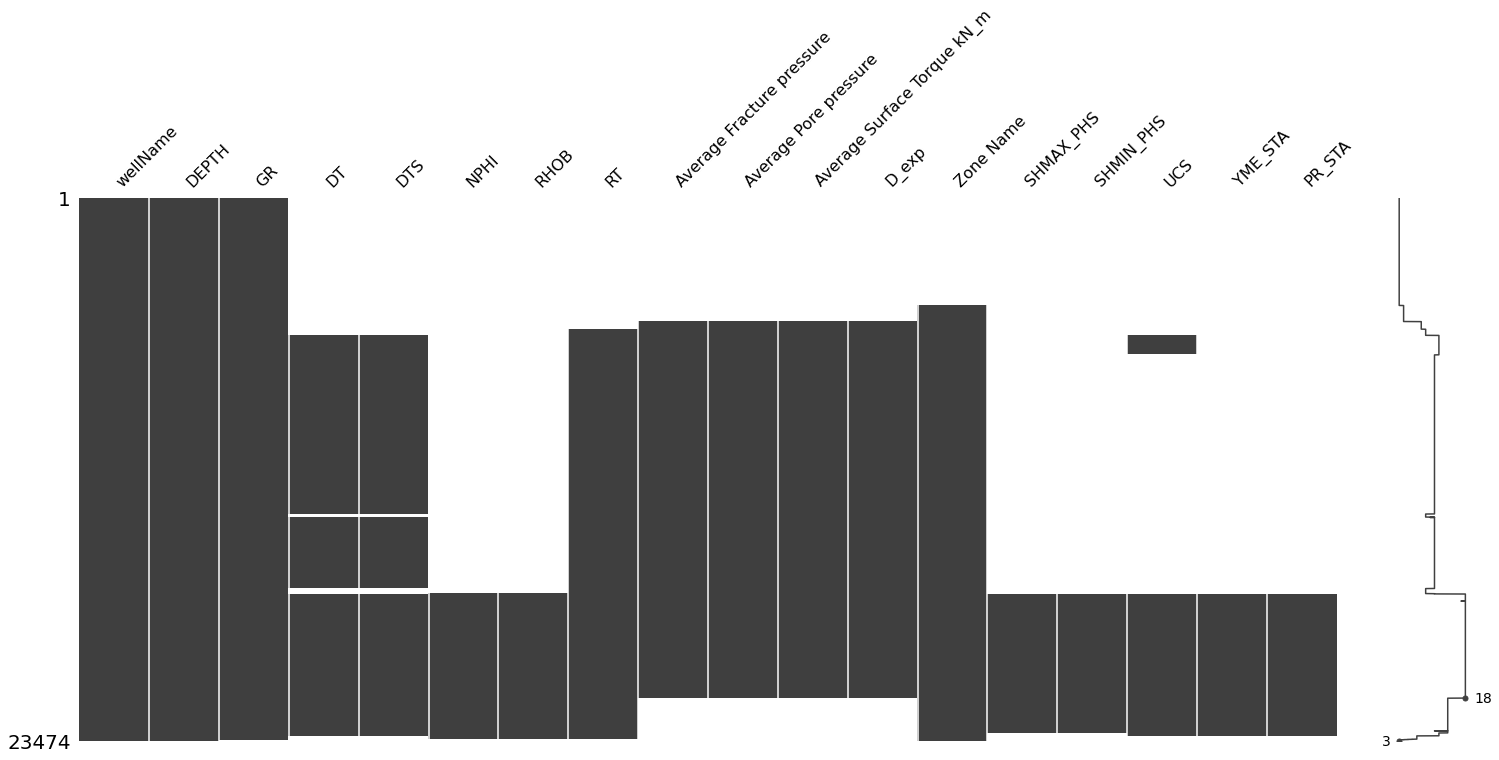

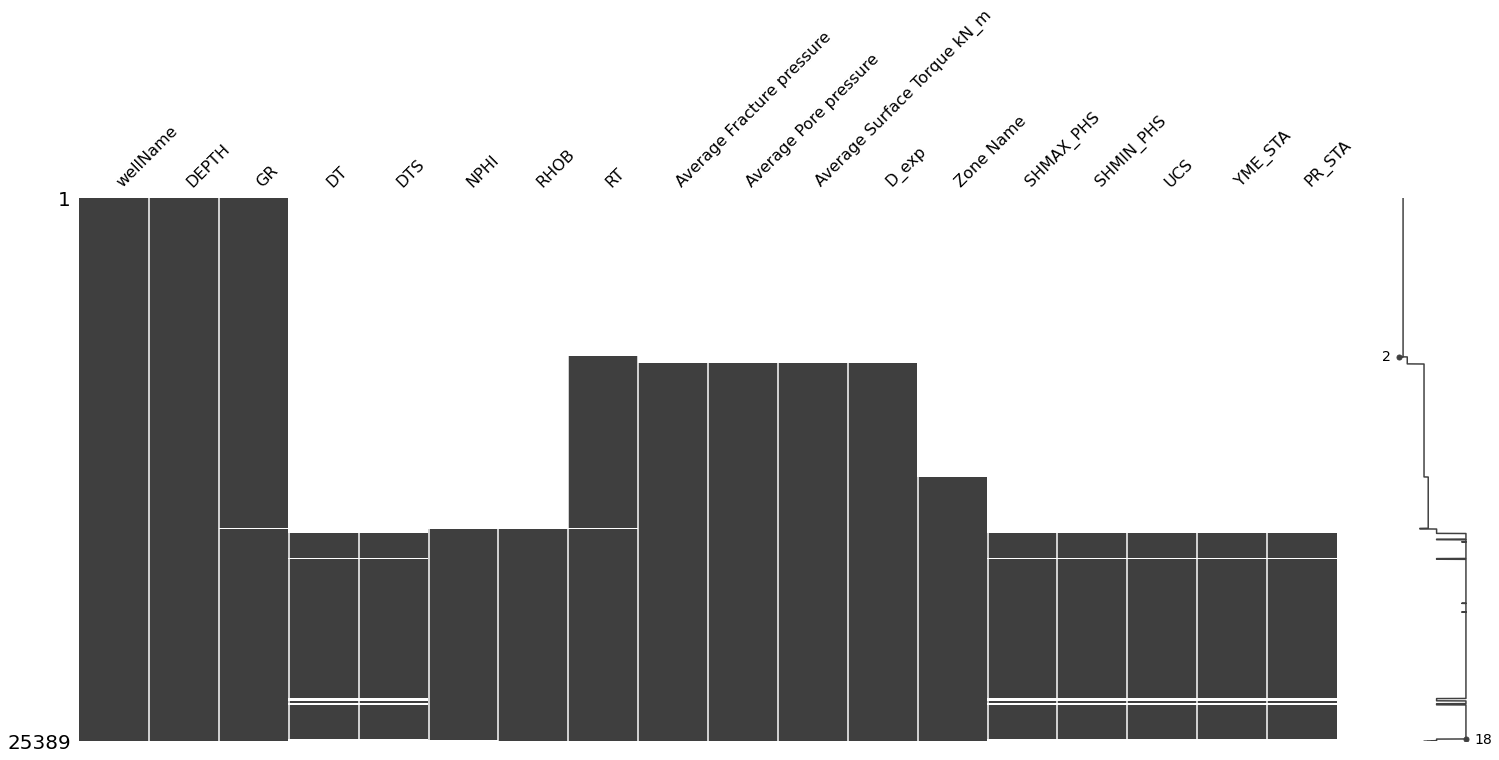

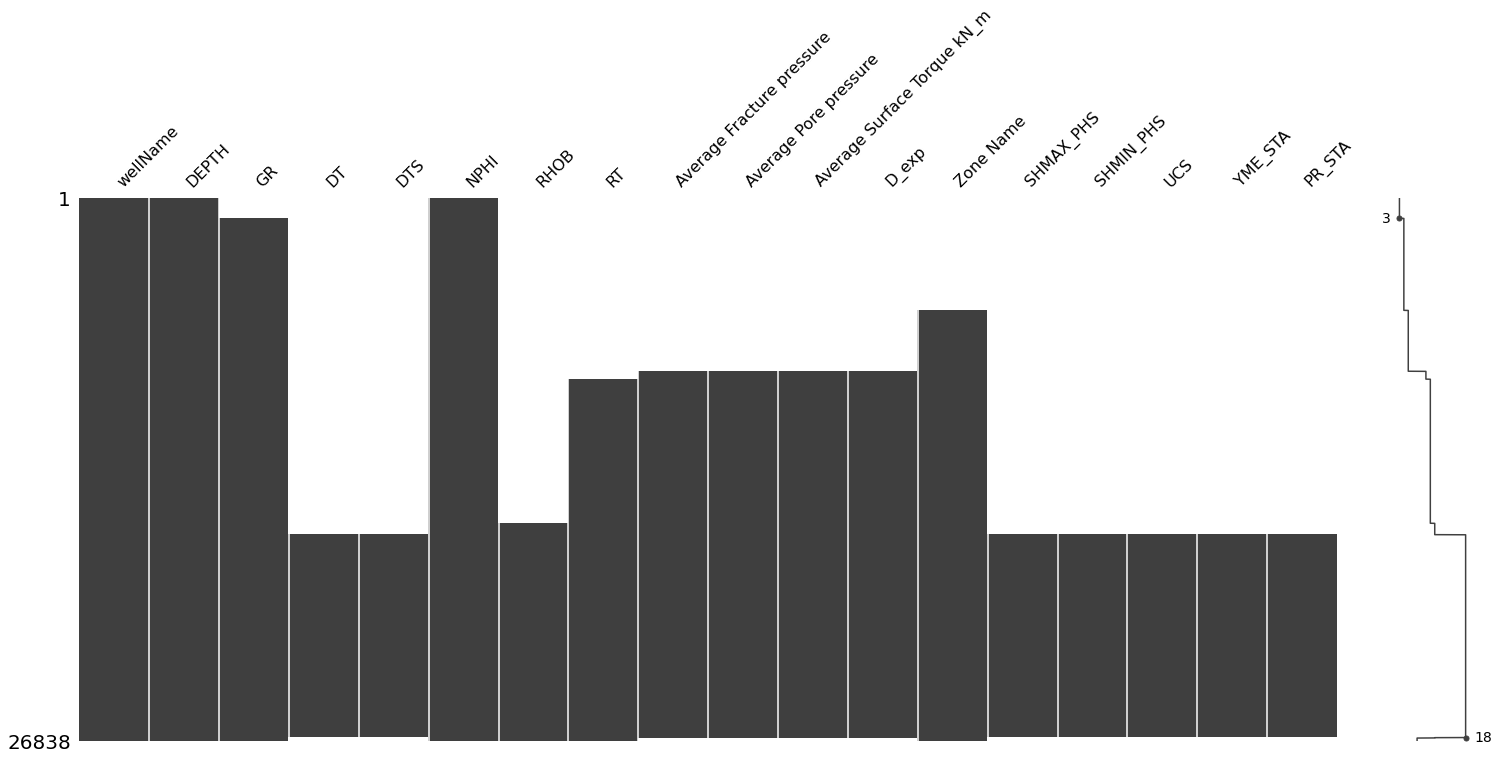

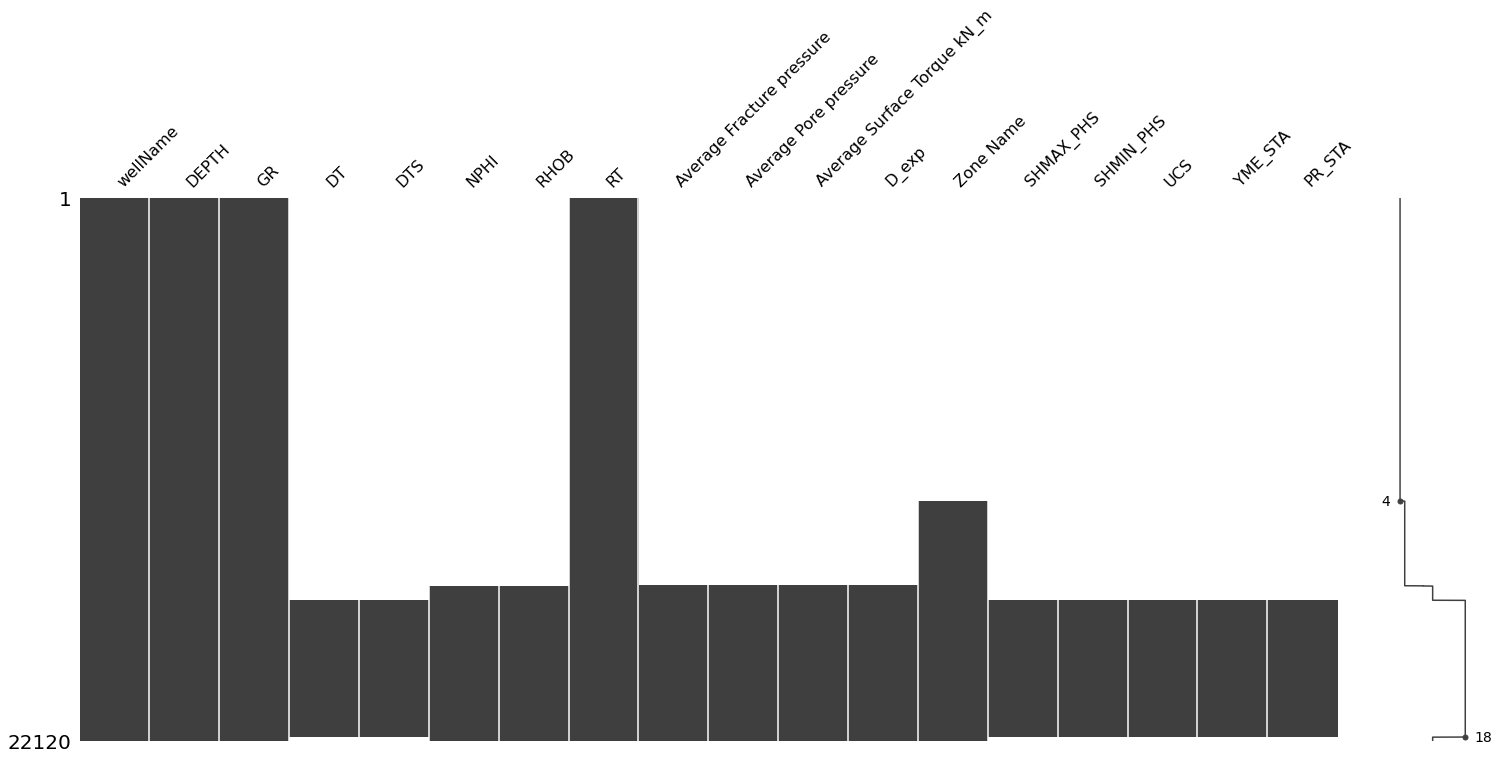

In [11]:
# A function for data couverage across multiple data frames
Data_couvrage(df_list)

Using the **Data_couvrage** function, Let's look at the overall **coverage** of the data for these parameters.
It appears that much of the data is not available in the individual wells, which is not uncommon in the acquisition process in drilling operations, as acquisition of these parameters is quite expensive, the gaps are usually always present.

In terms of mitigation, we are not going to interpolate or estimate the parameters, because of the size of the gaps. So we will simply drop the incomplete instances and train the final model only on the complete observations, which will of course affect the model prediction in terms of bias, but it is better than creating synthetic data.

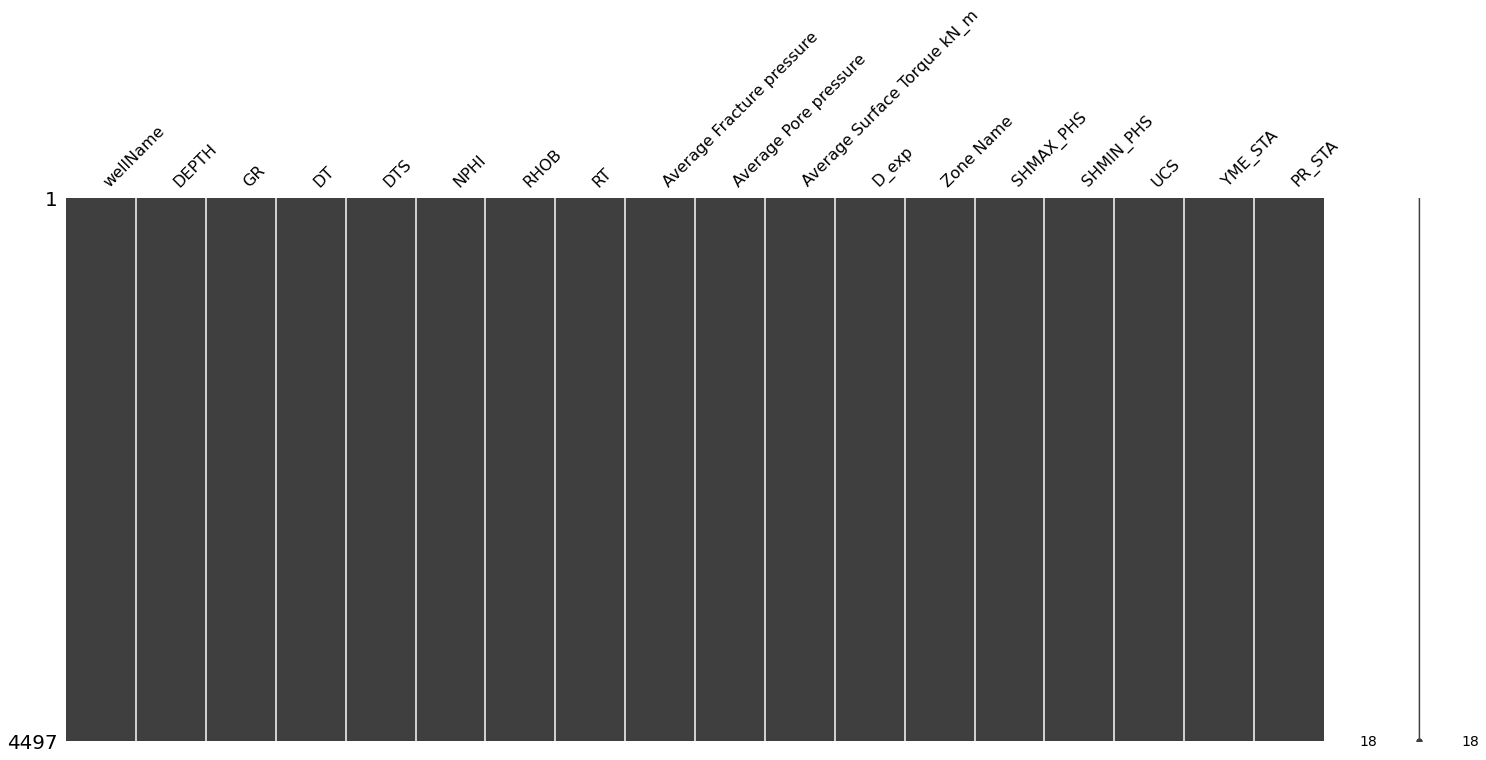

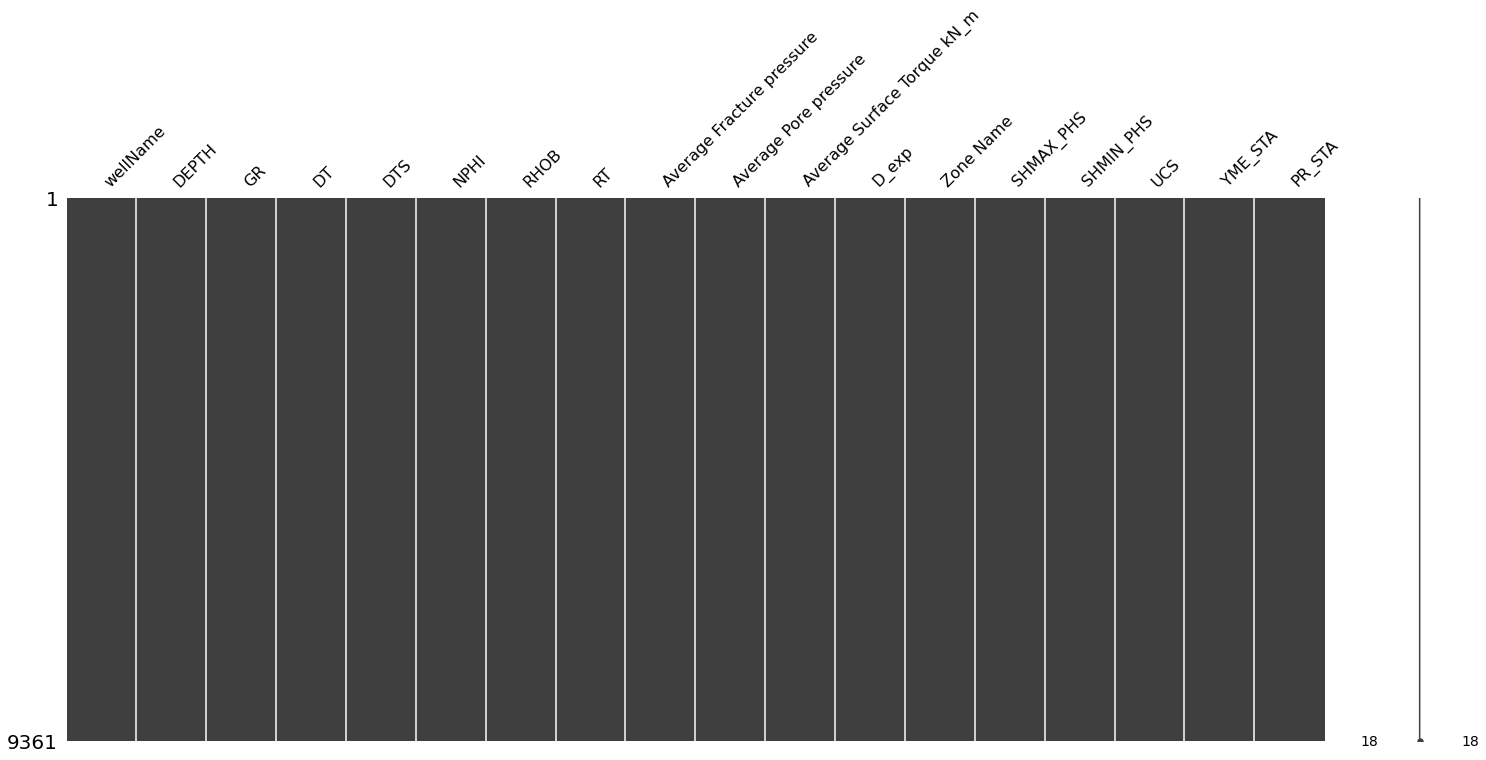

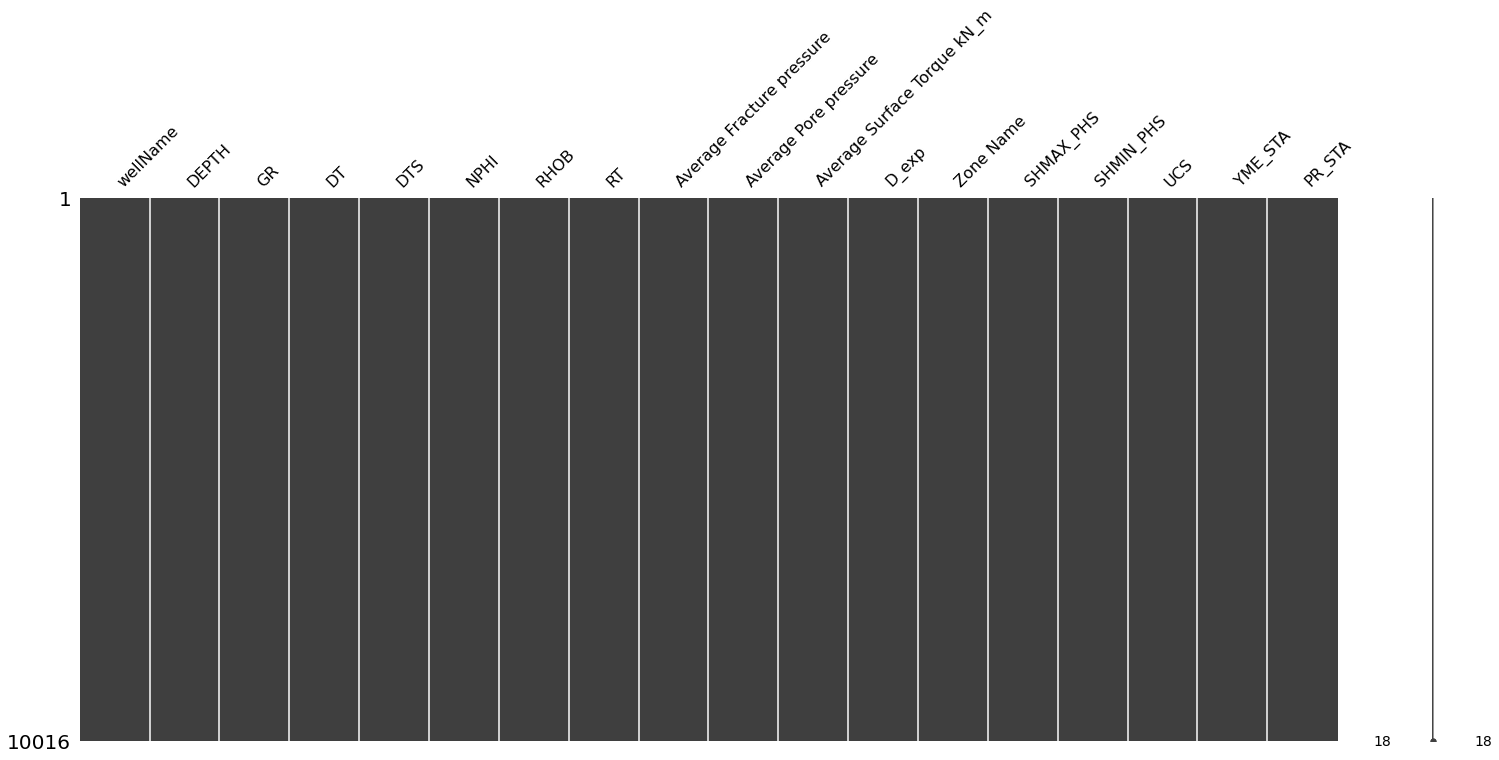

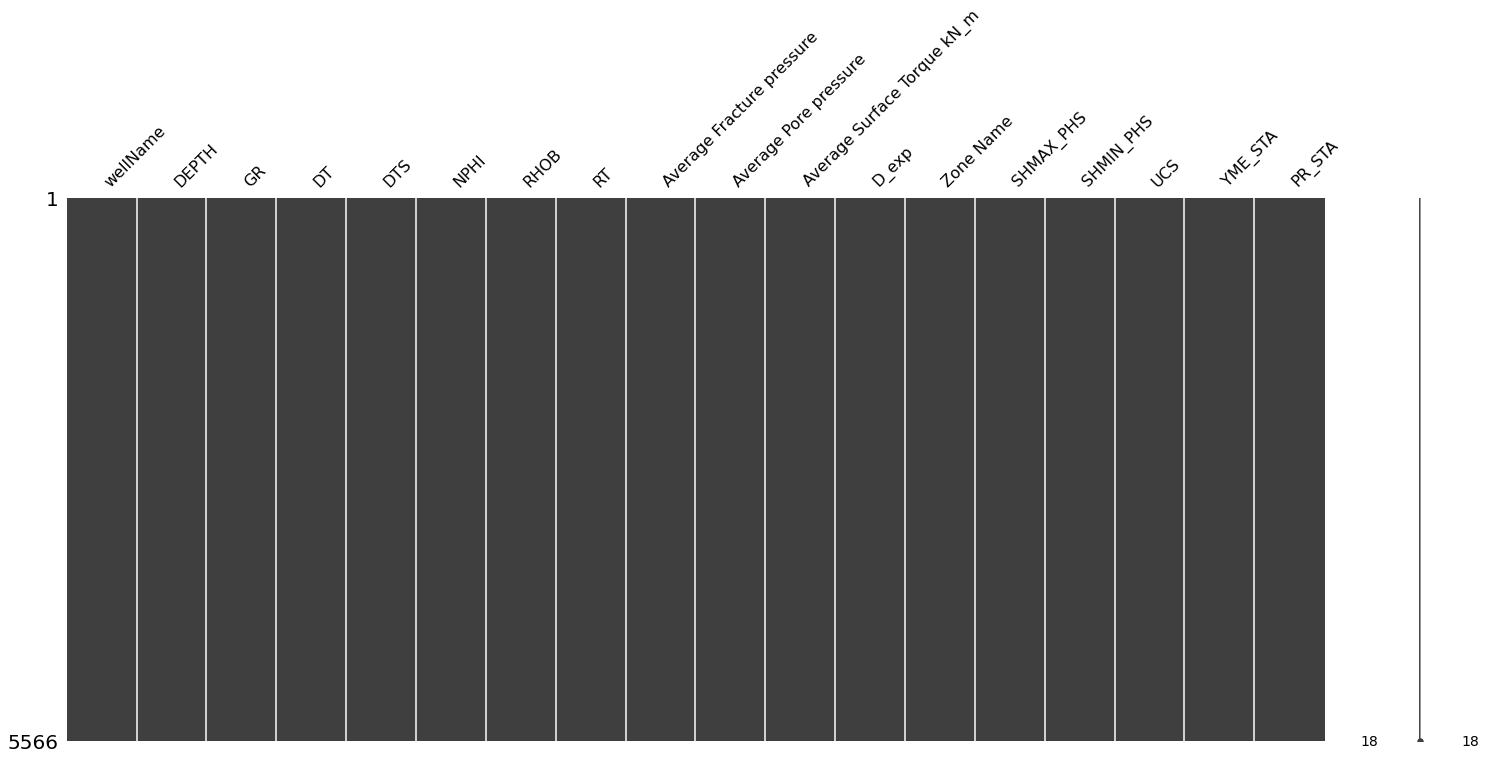

In [13]:
# Dropping the missing values in all the wells
for df in mod_df_list:
    df.dropna(inplace= True)

Data_couvrage(df_list)

Now that the data is smooth, we can move on to the remaining tasks.
Next we will simply encode the categorical features, at the beginning of the study multiple other "cat" parameters were included for analysis, but in the end we found very little correlation with the desired result, so we kept the "Zone name" only for **visualization** purposes.

The next block is a simple way to separate the categorical and numerical parameters, this is especially useful when we are dealing with large amounts of data that exceed 100 variables.

We are using a **label encoder**, as the " zone name" will not be used in the learning process, so there is no fear of potential hierarchy issues in the numbering. Another very **important note**, make sure the data is merged before encoding, if this is not done correctly, there will be inconsistencies in the encoding as each DataFrame will be processed individually.

In [14]:
df_list=mod_df_list
# Separation for list of dataframes
num_dfs=[]
for df in df_list:
    num_df=df.select_dtypes(include=np.number)
    num_dfs.append(num_df)
    
cat_dfs=[]
for df in df_list:
    cat_df=df.select_dtypes(include=np.number)
    cat_dfs.append(cat_df)
    

num_data=df_list[0].select_dtypes(include=np.number)
num_cols=num_data.columns.tolist()

cat_data=df_list[0].select_dtypes(exclude=np.number)
cat_cols=cat_data.columns.tolist()

Backup_1= df_list.copy()

label_Formation = LabelEncoder()
All_wells['Zone Name']=label_Formation.fit_transform(All_wells['Zone Name'])

Let's rename some parameters for aesthetic reasons.

In [20]:
# Renaminig the columns
col_names={'DEPTH':'MD',
           'Average Fracture pressure': 'FP', 
           'Average Pore pressure': 'PP',
           'Mud Density In g/cm3': 'Mud density',
           'Average Rotary Speed rpm': 'RPM', 
           'Rate of Penetration m/h':'ROP',
           'Average Standpipe Pressure kPa':'SPP',
           'Average Surface Torque kN_m': 'Torque', 
           'Weight on Bit kkgf': 'WOB',
           'Mud Flow In L/min': 'Mud flow',
           'Zone Name':'Formation',
           'SHMAX_PHS':'SH_max', 
           'SHMIN_PHS':'SH_min'}

for df in df_list:
    df.rename(columns=col_names,  inplace=True)

Let's see what's going on in the data, to do this and get a clearer view, we will plot **histograms** and **boxplots** for each parameter individually. We set logical **limits** for the gamma ray and neutron porosity that were noticed from the description function.

We also calculate the **logarithmic** function for the true resistivity in order to have a **more linear** variation, and also to avoid **problems related to data standardization and normalization**, as the range of variation is very large.

<Figure size 432x288 with 0 Axes>

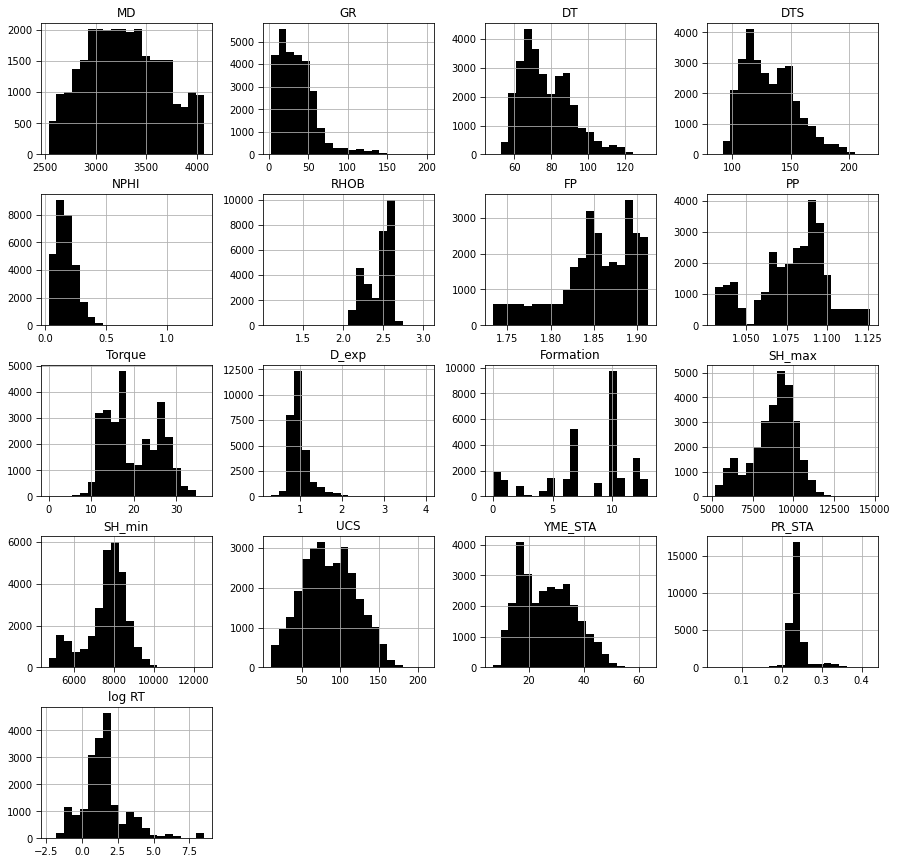

In [24]:
All_Data= pd.concat(well_list)
All_Data.reset_index(inplace=True)
All_Data.drop('index', axis=1, inplace= True)

# Setting the limits
All_Data=All_Data[All_Data['NPHI']>0]
All_Data=All_Data[All_Data['GR']<200]

# Computing the logarithmic for the true resistivity
All_Data['log RT']= np.log(All_Data['RT'])
All_Data.drop(['RT'], axis=1, inplace=True)

# Custom plotting for all the parameters across the DataFrames
Multi_hist(All_Data, columns=4, color='black')

We can already see a nice **Gaussian distribution** for most parameters. There is very little evidence of outliers at the moment, but let's plot the box plots to get a clearer picture.

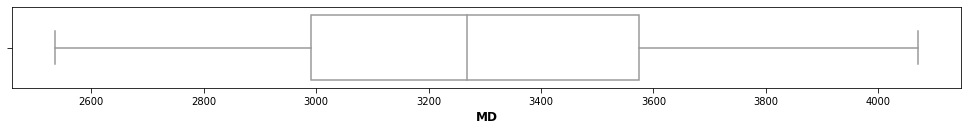

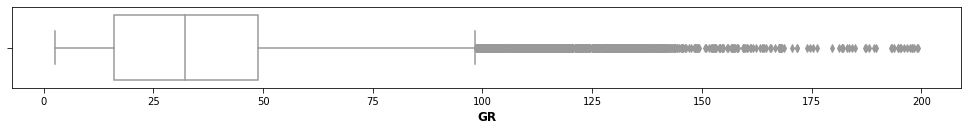

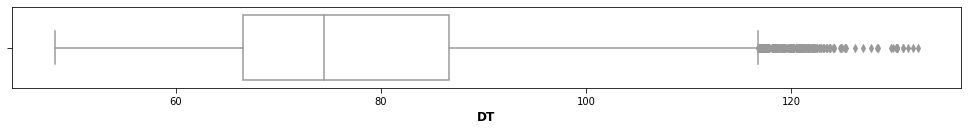

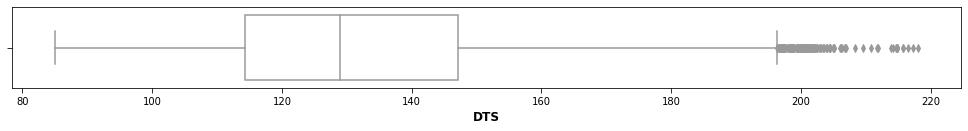

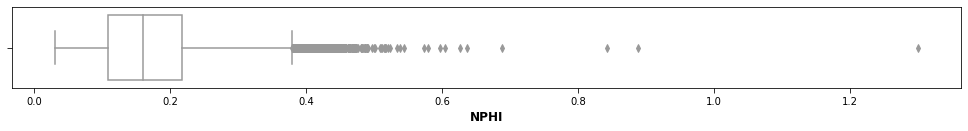

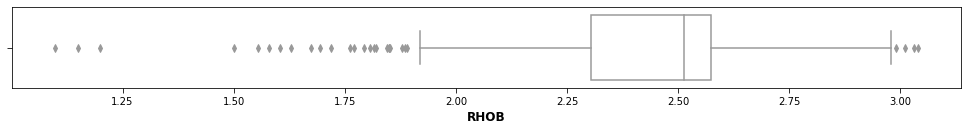

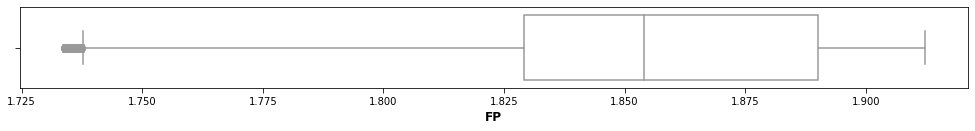

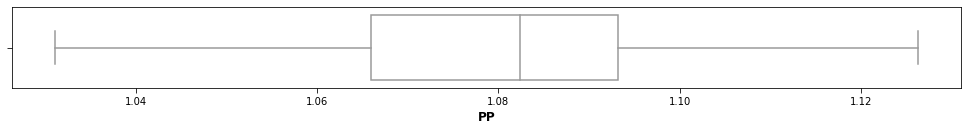

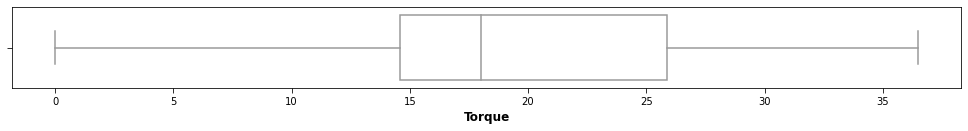

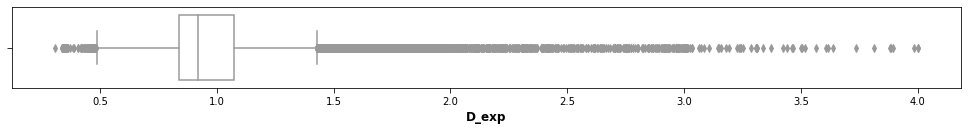

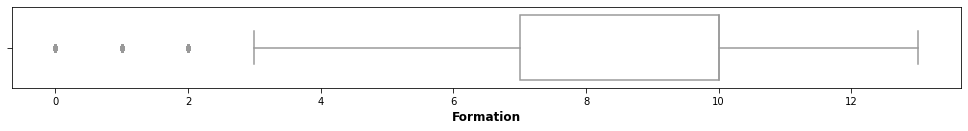

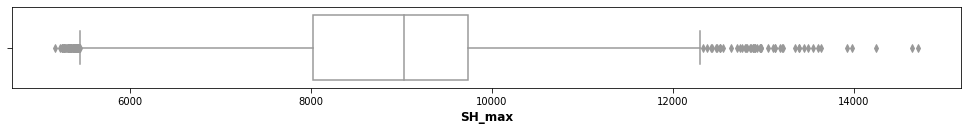

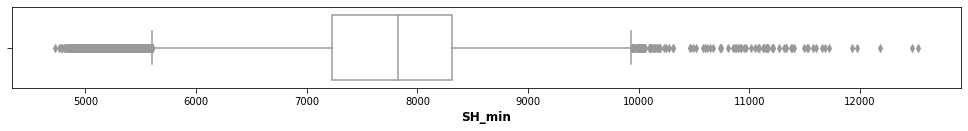

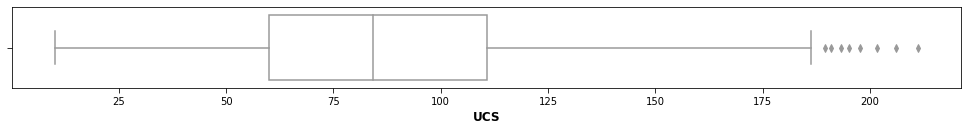

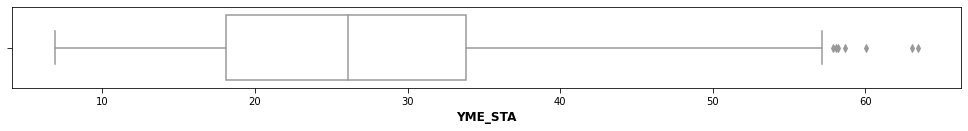

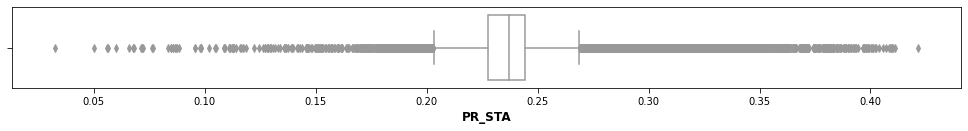

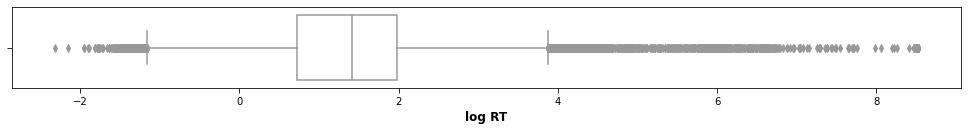

In [28]:
# Custom plotting for all the parameters across the DataFrames
Multi_boxplot(All_Data, plot='individual', oren='hor', color='white')

Indeed, the range of variation is logical, but there is always the **potential for outliers**, especially when combining different parameters and not individually. This will be investigated further using more **advanced algorithms**, before feeding the training data into the final model.

For more interesting information, let's look at the underlying relationship between the **desired parameters** for prediction ['SH_max', 'SH_min', 'UCS', 'YME_STA', 'PR_STA'] and the parameters that will be **used for training**, displayed **by the drilled formation** for deeper insights

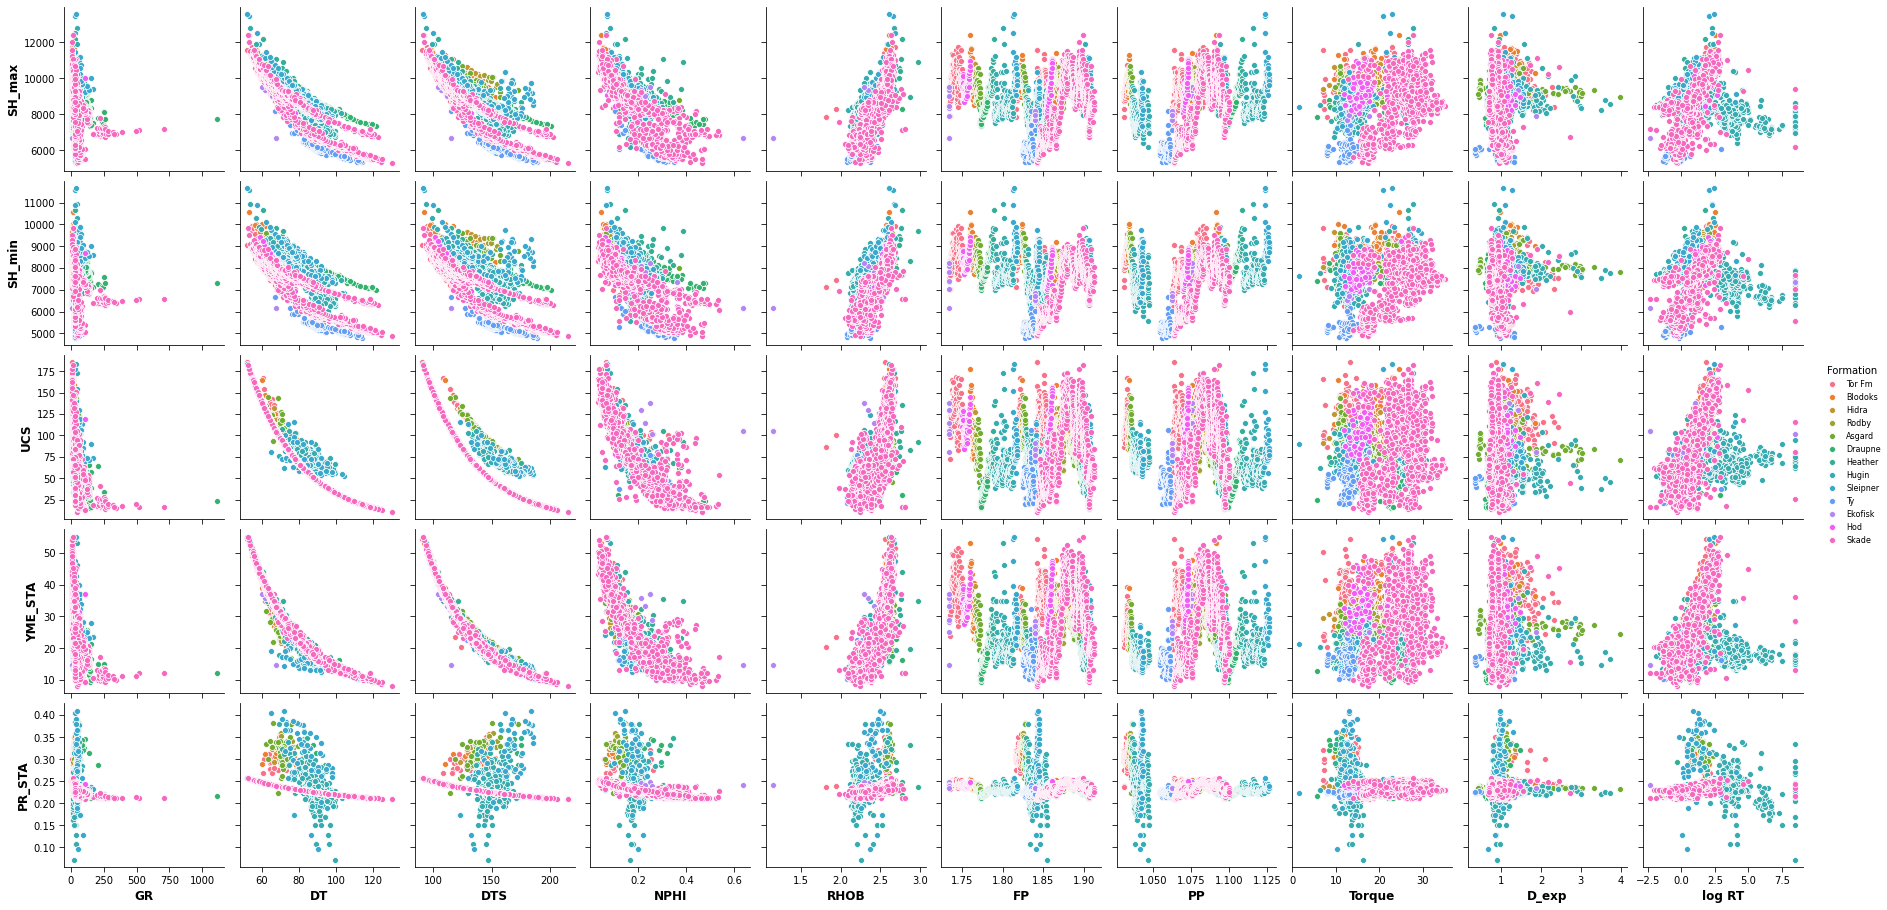

In [32]:
Multi_crossplot(data=All_Data, 
                x=['GR', 'DT', 'DTS', 'NPHI', 'RHOB', 'FP', 'PP', 'Torque', 'D_exp', 'log RT'],
                y=['SH_max', 'SH_min', 'UCS', 'YME_STA', 'PR_STA'], 
                color='Formation')

It is quite obvious that the most correlative parameters include common **well logs** such as compression, shear slowness, density, etc.
Parameters such as torque and exponent D have only relative meaning in the **context of the specific formation**, which is not really interesting in the framework of general modeling. But it might be useful if the final model were based on lithology. 

Let's calculate the correlation between each parameter to quantify the relationship.

<AxesSubplot:>

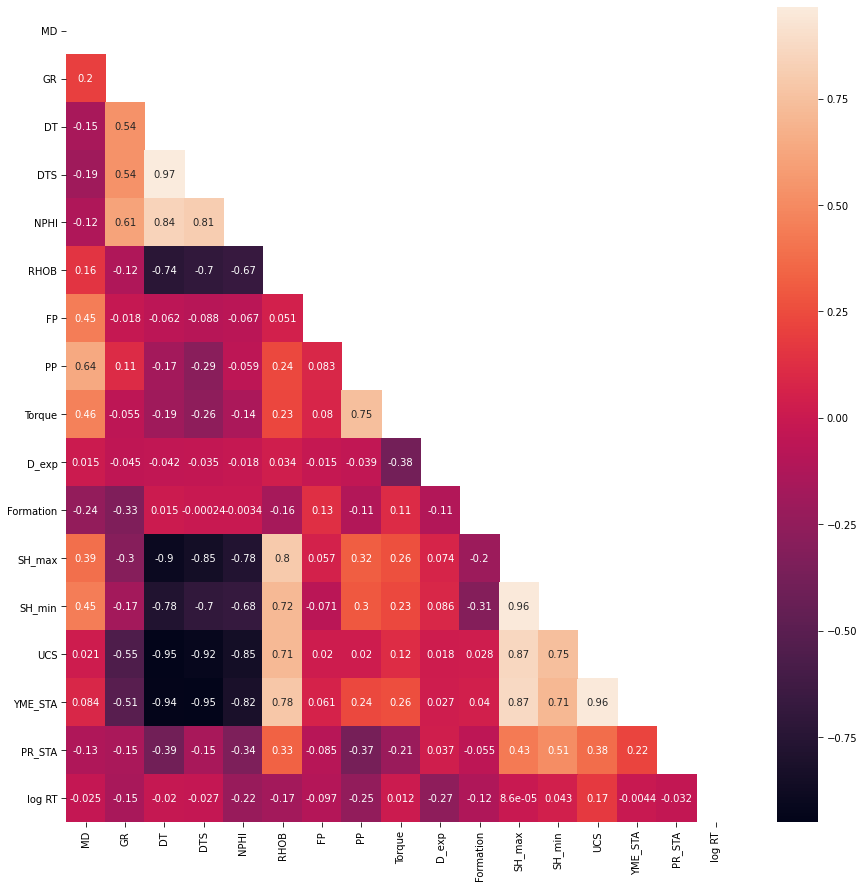

In [33]:
fig=plt.figure(figsize=(15,15))
corr= All_Data.corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

# using the upper triangle matrix as mask 
sns.heatmap(corr, annot=True, mask=matrix)

Finally, the heat map speaks for itself. In order to have a more efficient model, we will use those that have a strong correlation with the model (high positive and negative), and we will drop the others.

Let us now take a three-dimensional perspective of these relationships. With a fourth perspective being color (I don't like to call it 4D).

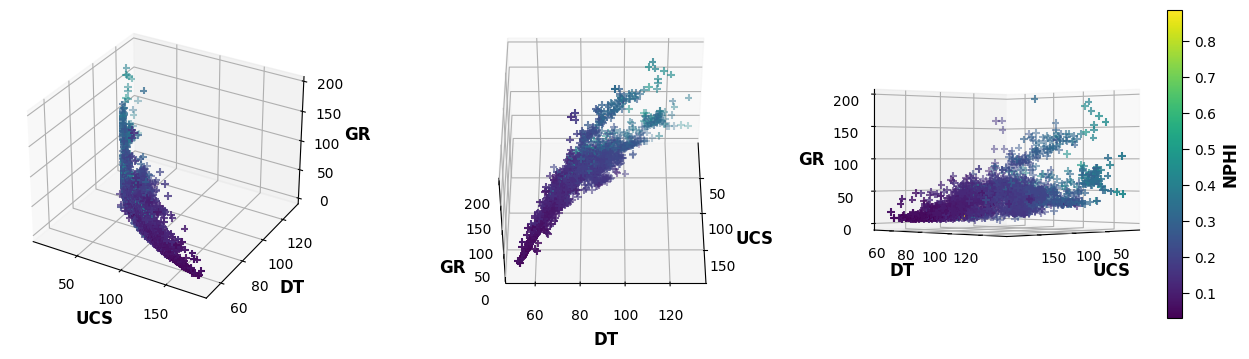

In [39]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt

data=All_Data.copy()

# Custom 3D plot using matplotlib
Triple_angle_3D(data, fig_ratio=0.25,
                X = data['UCS'],Y = data['DT'], Z = data['GR'], color=data['NPHI'], 
                plot_type= 'scatter', marker='+', size=30 )

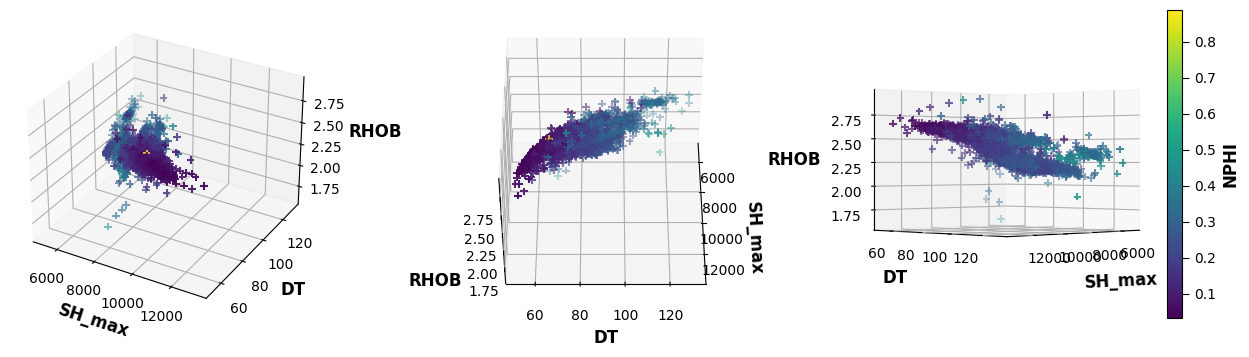

In [47]:
Triple_angle_3D(data, fig_ratio=0.25,
                X = data['SH_max'],Y = data['DT'], Z = data['RHOB'], color=data['NPHI'], 
                plot_type= 'scatter', marker='+', size=30 )

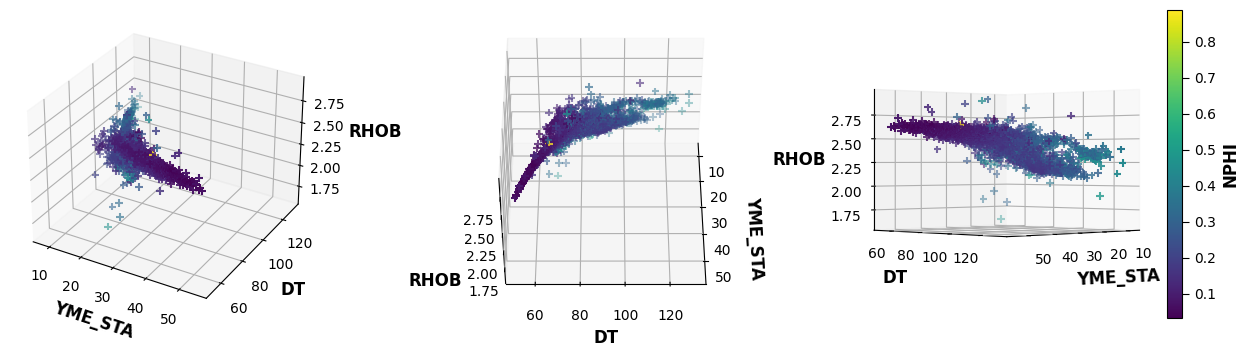

In [52]:
Triple_angle_3D(data, fig_ratio=0.25,
                X = data['YME_STA'],Y = data['DT'], Z = data['RHOB'], color=data['NPHI'], 
                plot_type= 'scatter', marker='+', size=30 )

Since the relationship between the different perspectives is very clear, a machine learning model with the following inputs and more, will easily be able to identify the pattern.

The relationships seem to make sense in the general context, a stiffer rock has lower values for neutron porosity, which translates into its inability to store any type of fluids, which also coincides with a lower compressional slowness.

You can also use the code below to generate an interactive visual with plotly, but it is not necessary in our case.

In [238]:
# Create an interactive visual using plotly
import plotly.express as px
fig = px.scatter_3d(data, x=data['UCS'], y=data['Torque'], z=data['D_exp'],
                    color=data['MD'], size_max=10)
fig.show()

Now let's use the MinMaxScaler to put the data in a suitable range, avoiding promlems when it comes to the utilization of distance based mahine learning algorithms.

We are also creating scalers for the input and desired inputs respectively, to use them latter for the test wells.

# 3. Data Advanced Processing

In [54]:
# Creating a copy of the data
Data_oi=All_Data.copy()


features=['MD', 'GR', 'DT', 'DTS', 'NPHI', 'RHOB', 'FP', 'PP',
          'Torque', 'D_exp', 'SH_max', 'SH_min', 'UCS', 'YME_STA',
          'PR_STA', 'log RT']
features_stnd= Data_oi[['MD', 'GR', 'DT', 'DTS', 'NPHI', 'RHOB', 'log RT']]
Target_stnd= Data_oi[['SH_max', 'SH_min', 'UCS', 'YME_STA', 'PR_STA']]


data_stnd= Data_oi[['MD', 'GR', 'DT', 'DTS', 'NPHI', 'RHOB', 'FP', 'PP',
                    'Torque', 'D_exp', 'SH_max', 'SH_min', 'UCS', 'YME_STA',
                    'PR_STA', 'log RT']]

# Initiating and fitting the scaler
min_max_scaler = MinMaxScaler()
data_stnd = min_max_scaler.fit_transform(data_stnd)

# Re-converting the data to a DataFrame
data_stnd = pd.DataFrame(data_stnd, columns=features)
data_stnd['Formation']=Data_oi['Formation']

# Scaling the features only
min_max_scaler_features = MinMaxScaler()
features_stnd = min_max_scaler_features.fit_transform(features_stnd)

# Scaling the outputs only
min_max_scaler_target = MinMaxScaler()
Target_stnd = min_max_scaler_target.fit_transform(Target_stnd)

Now, to detect more complex outliers (which do not make sense in context), we will use a set of versatile techniques that are more commonly used in unsupervised learning problems, including **Isolation Forest**, **Minimum Covariance**, **Local Outlier Factor**, and **Single Class SVM**.

Number of points before outliers removed                       : 19300
Number of points after outliers removed with Standard Deviation: 19300
Number of points after outliers removed with Isolation Forest  : 9650
Number of points after outliers removed with Min. Covariance   : 17370
Number of points after outliers removed with Outlier Factor    : 13510
Number of points after outliers removed with One-class SVM     : 17371


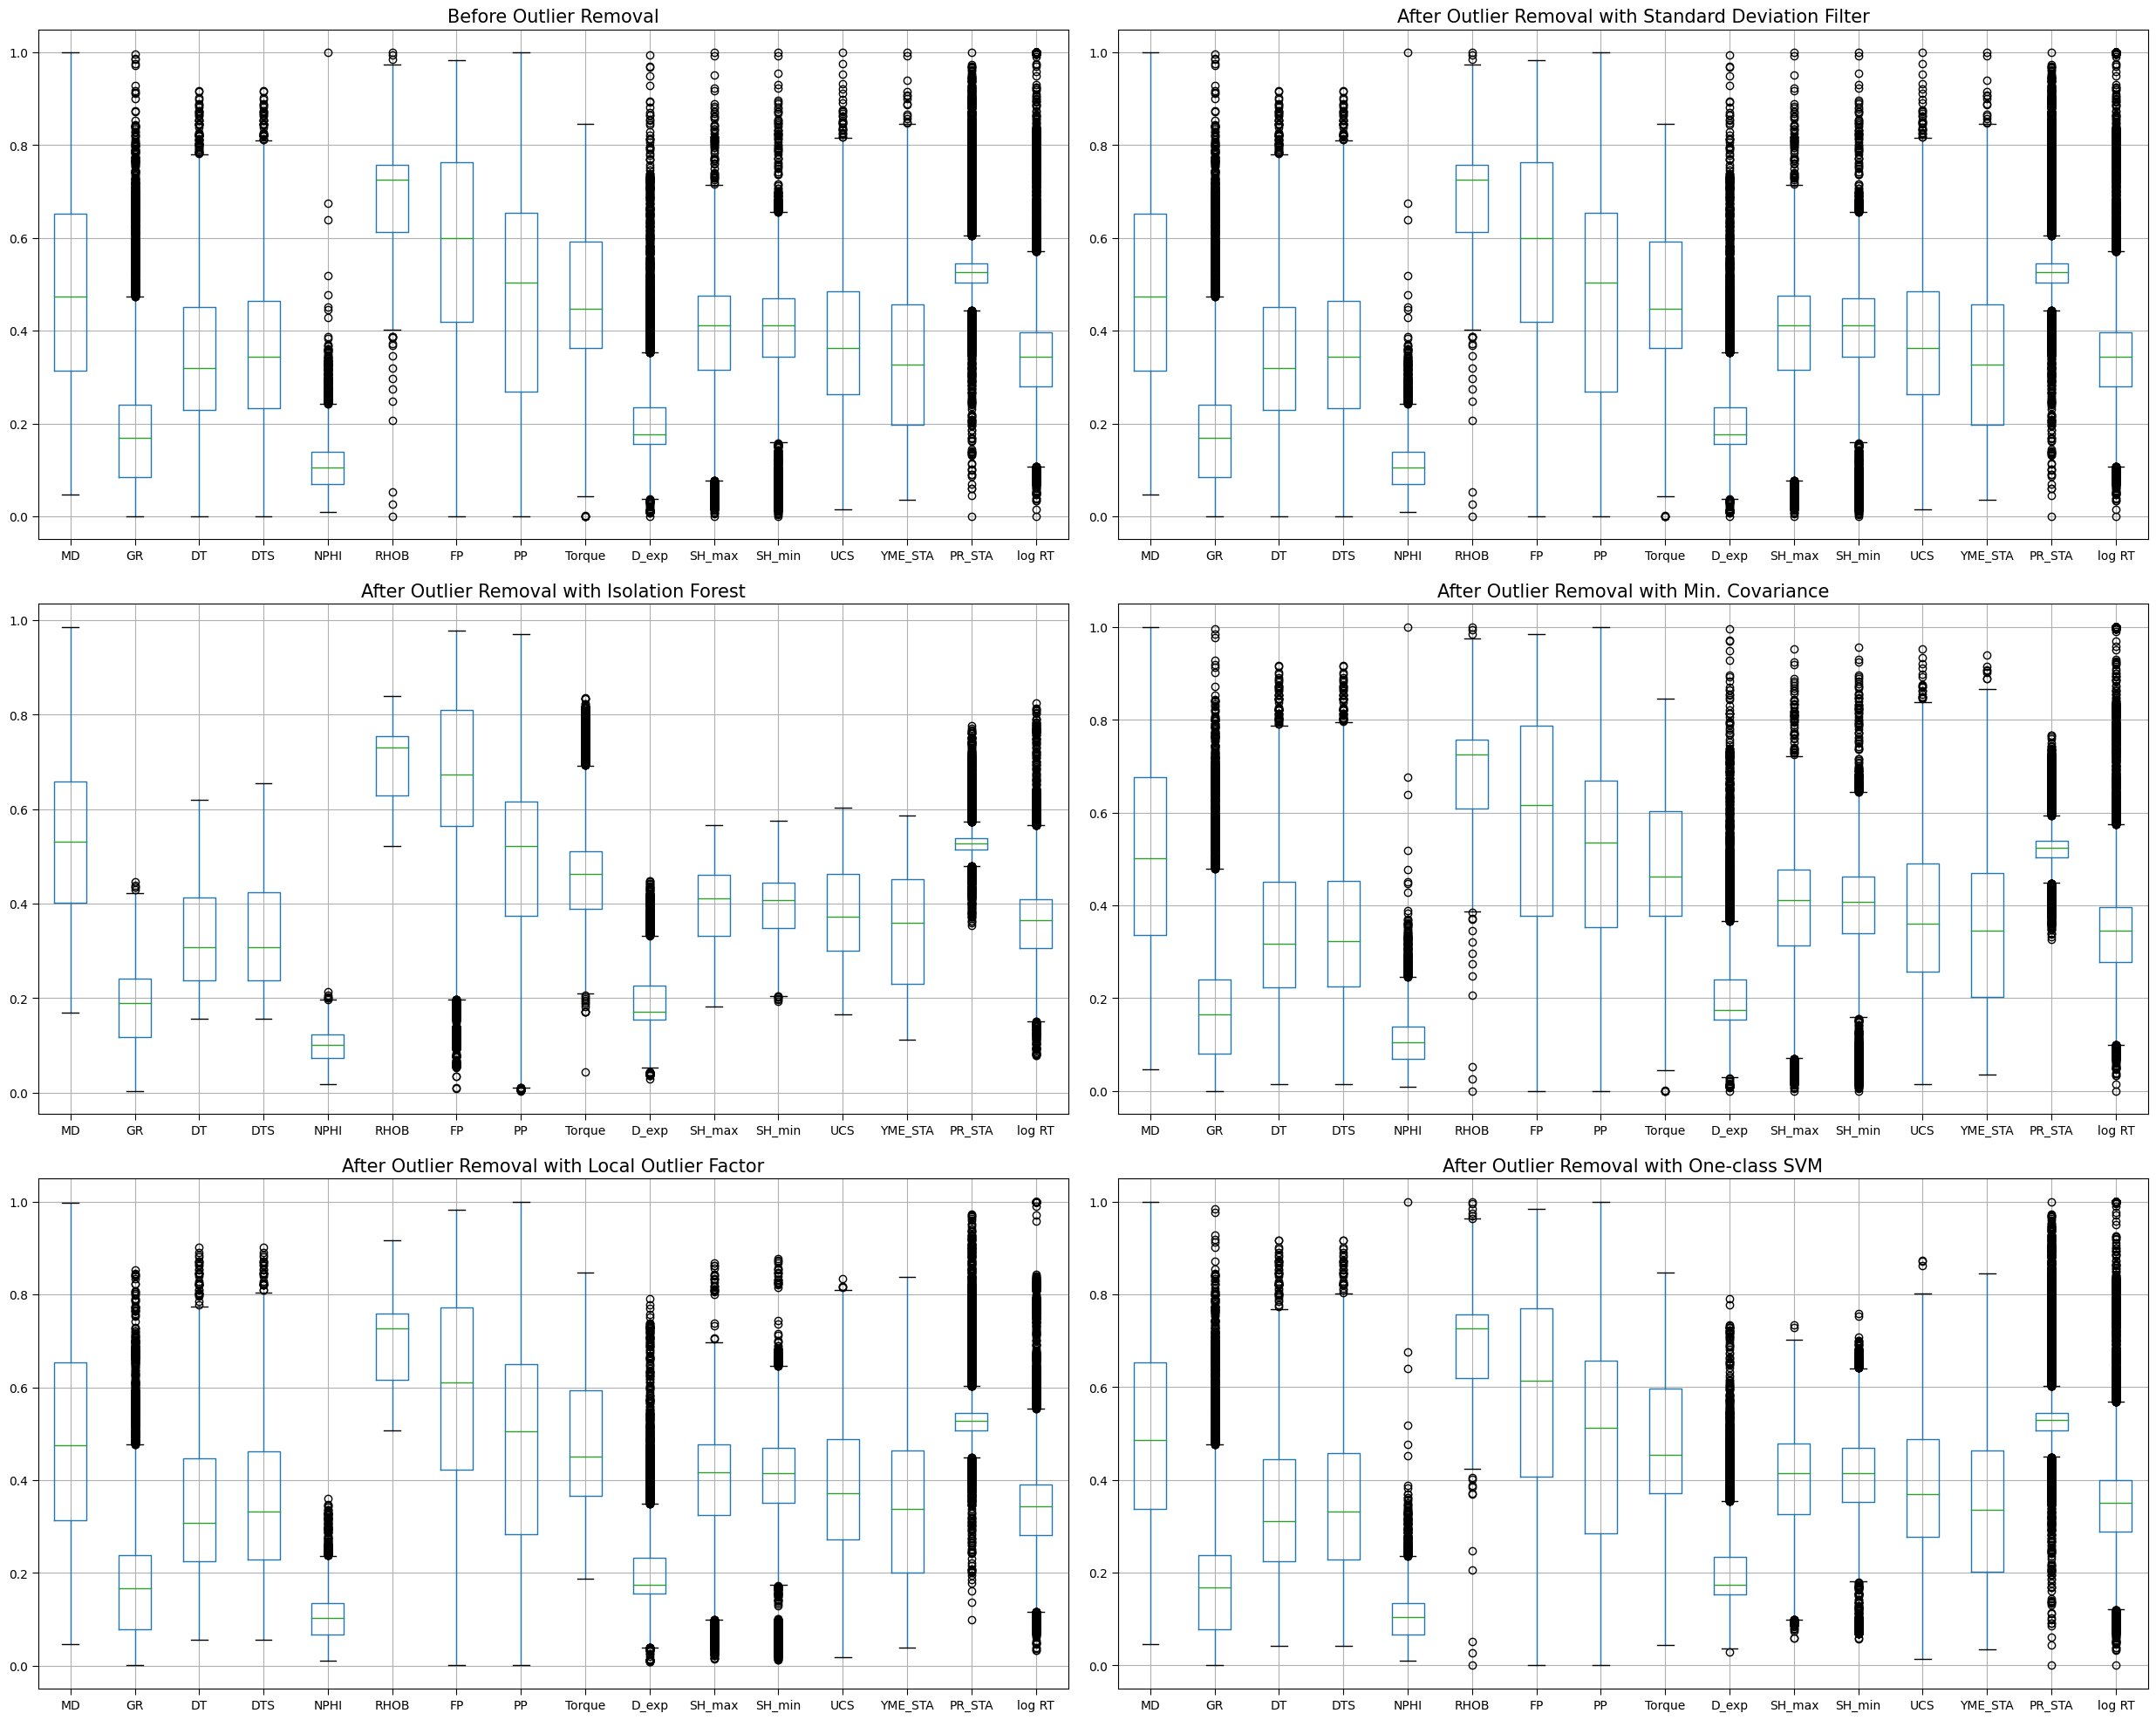

In [56]:
data_stnd_drop=data_stnd.copy()
data_stnd_drop.dropna(inplace=True)

# Custom function for outlier detection and ploting
adv_out_loc(data=data_stnd_drop, methods=['std_d', 'iso_f', 'm_c', 'lof', 'svm'] , cont_value=0.1)

Upon closer inspection of the boxplots, we will opt for the output generated by One_class SVM, as it managed to reduce the variance without affecting the data set substantially, as is the case with the other method. The distribution plot confirmed the latter choice.

Removing outliers does in most of cases improve the overall distribution and clears the correlations between the parameters, so let's inspect that again.

<Figure size 640x480 with 0 Axes>

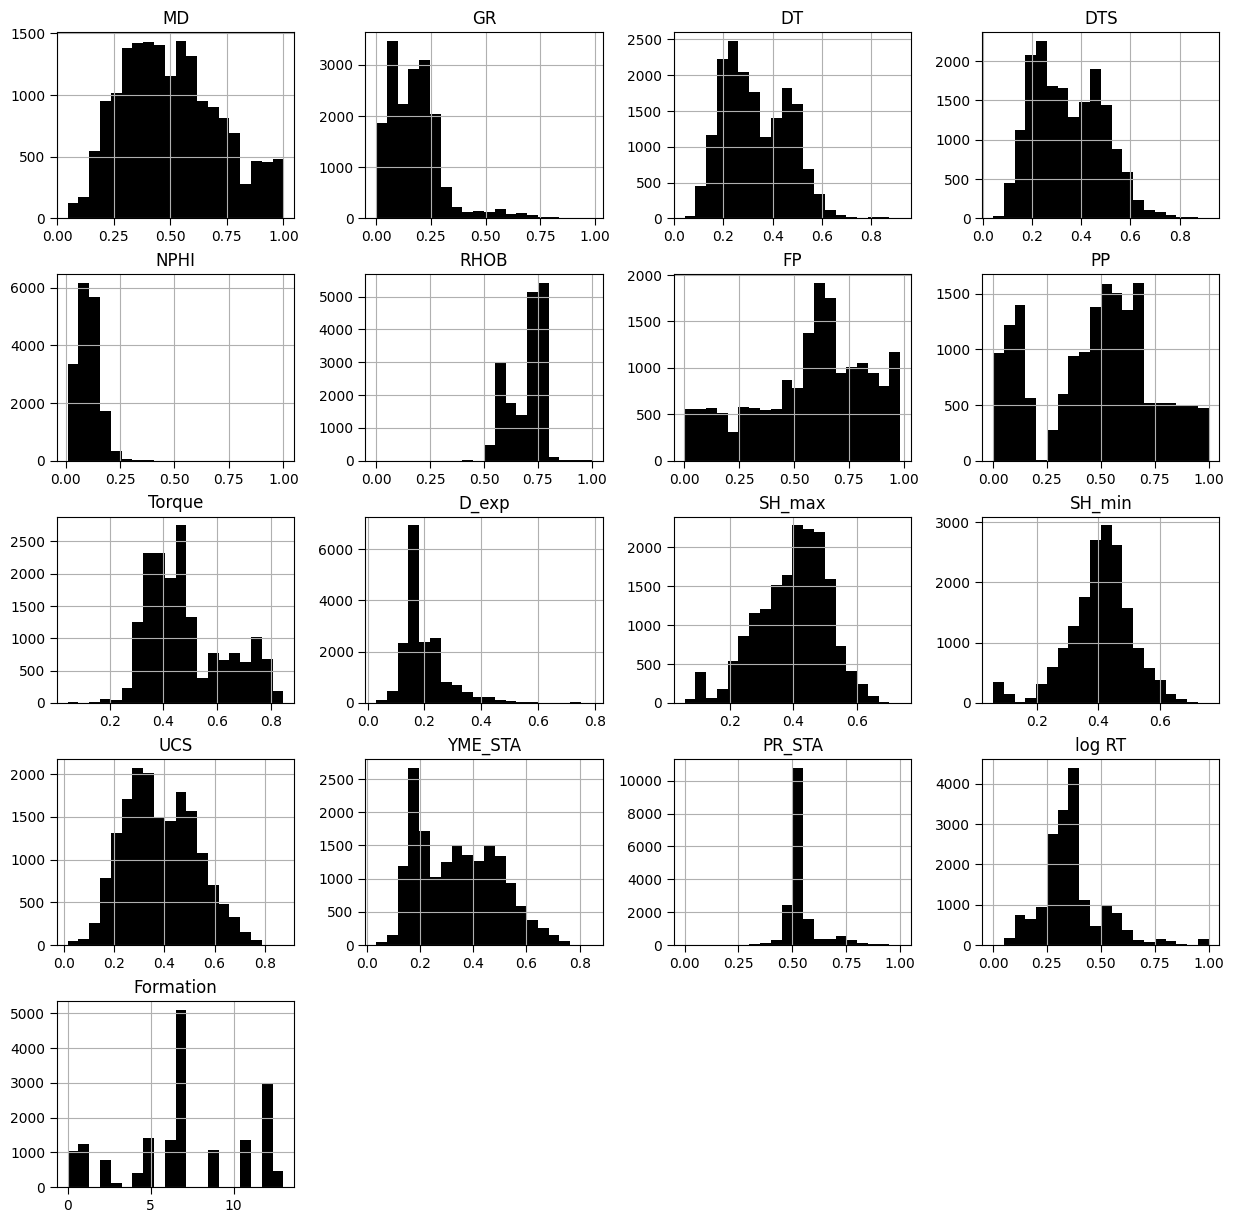

In [58]:
train_svm.reset_index(inplace=True)
train_svm.drop('index', axis=1, inplace=True)
Multi_hist(train_svm, columns=4, color='black')

<AxesSubplot:>

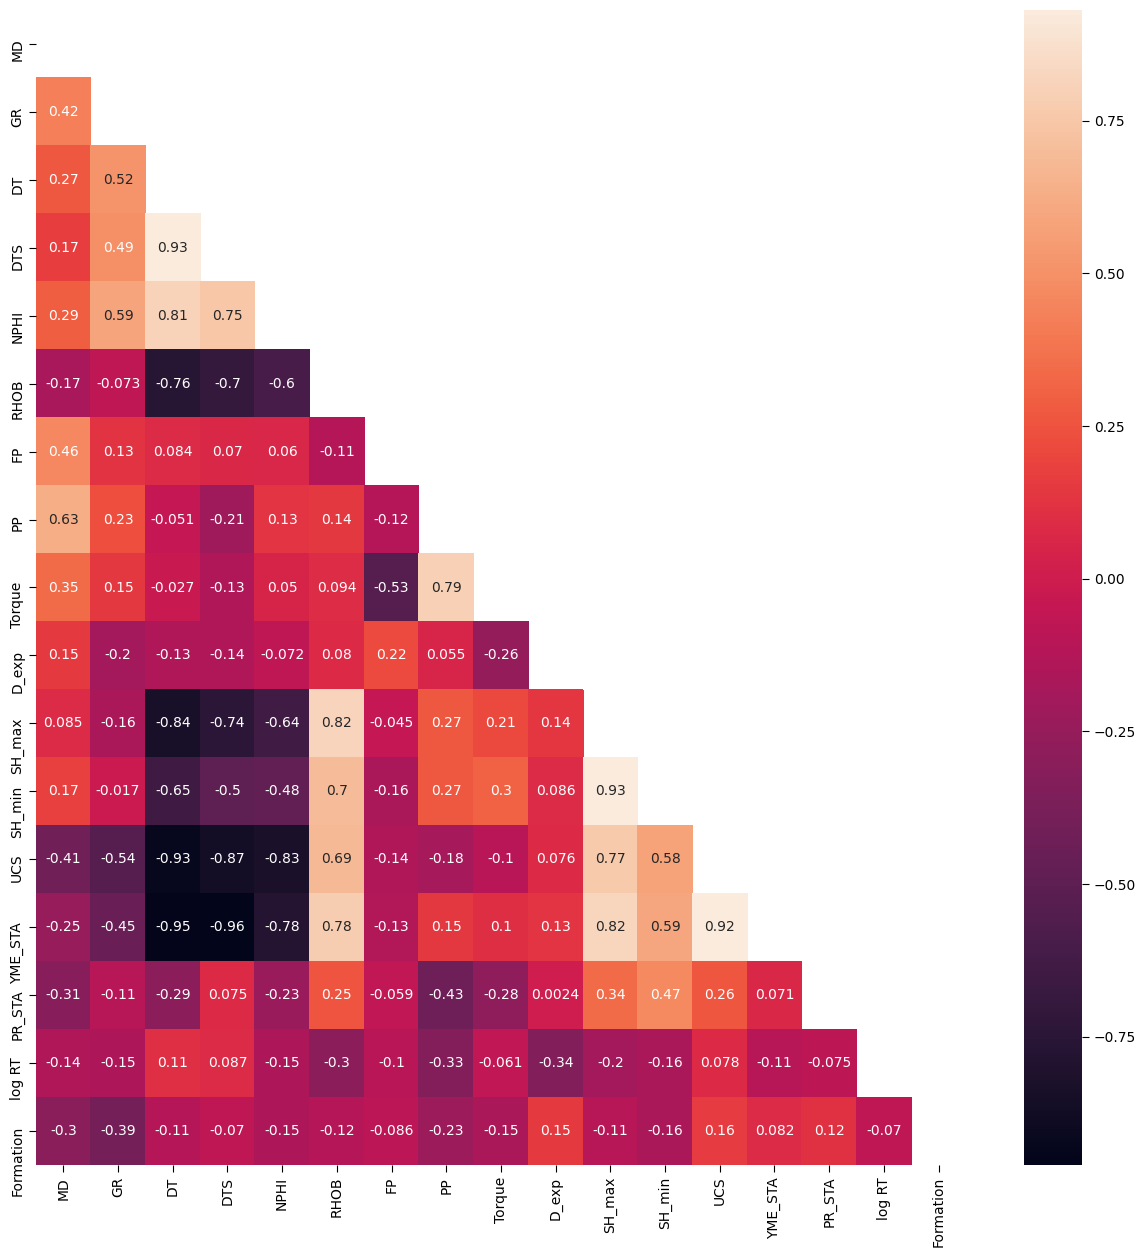

In [59]:
fig=plt.figure(figsize=(15,15))
corr= train_svm.corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

# using the upper triangle matrix as mask 
sns.heatmap(corr, annot=True, mask=matrix)

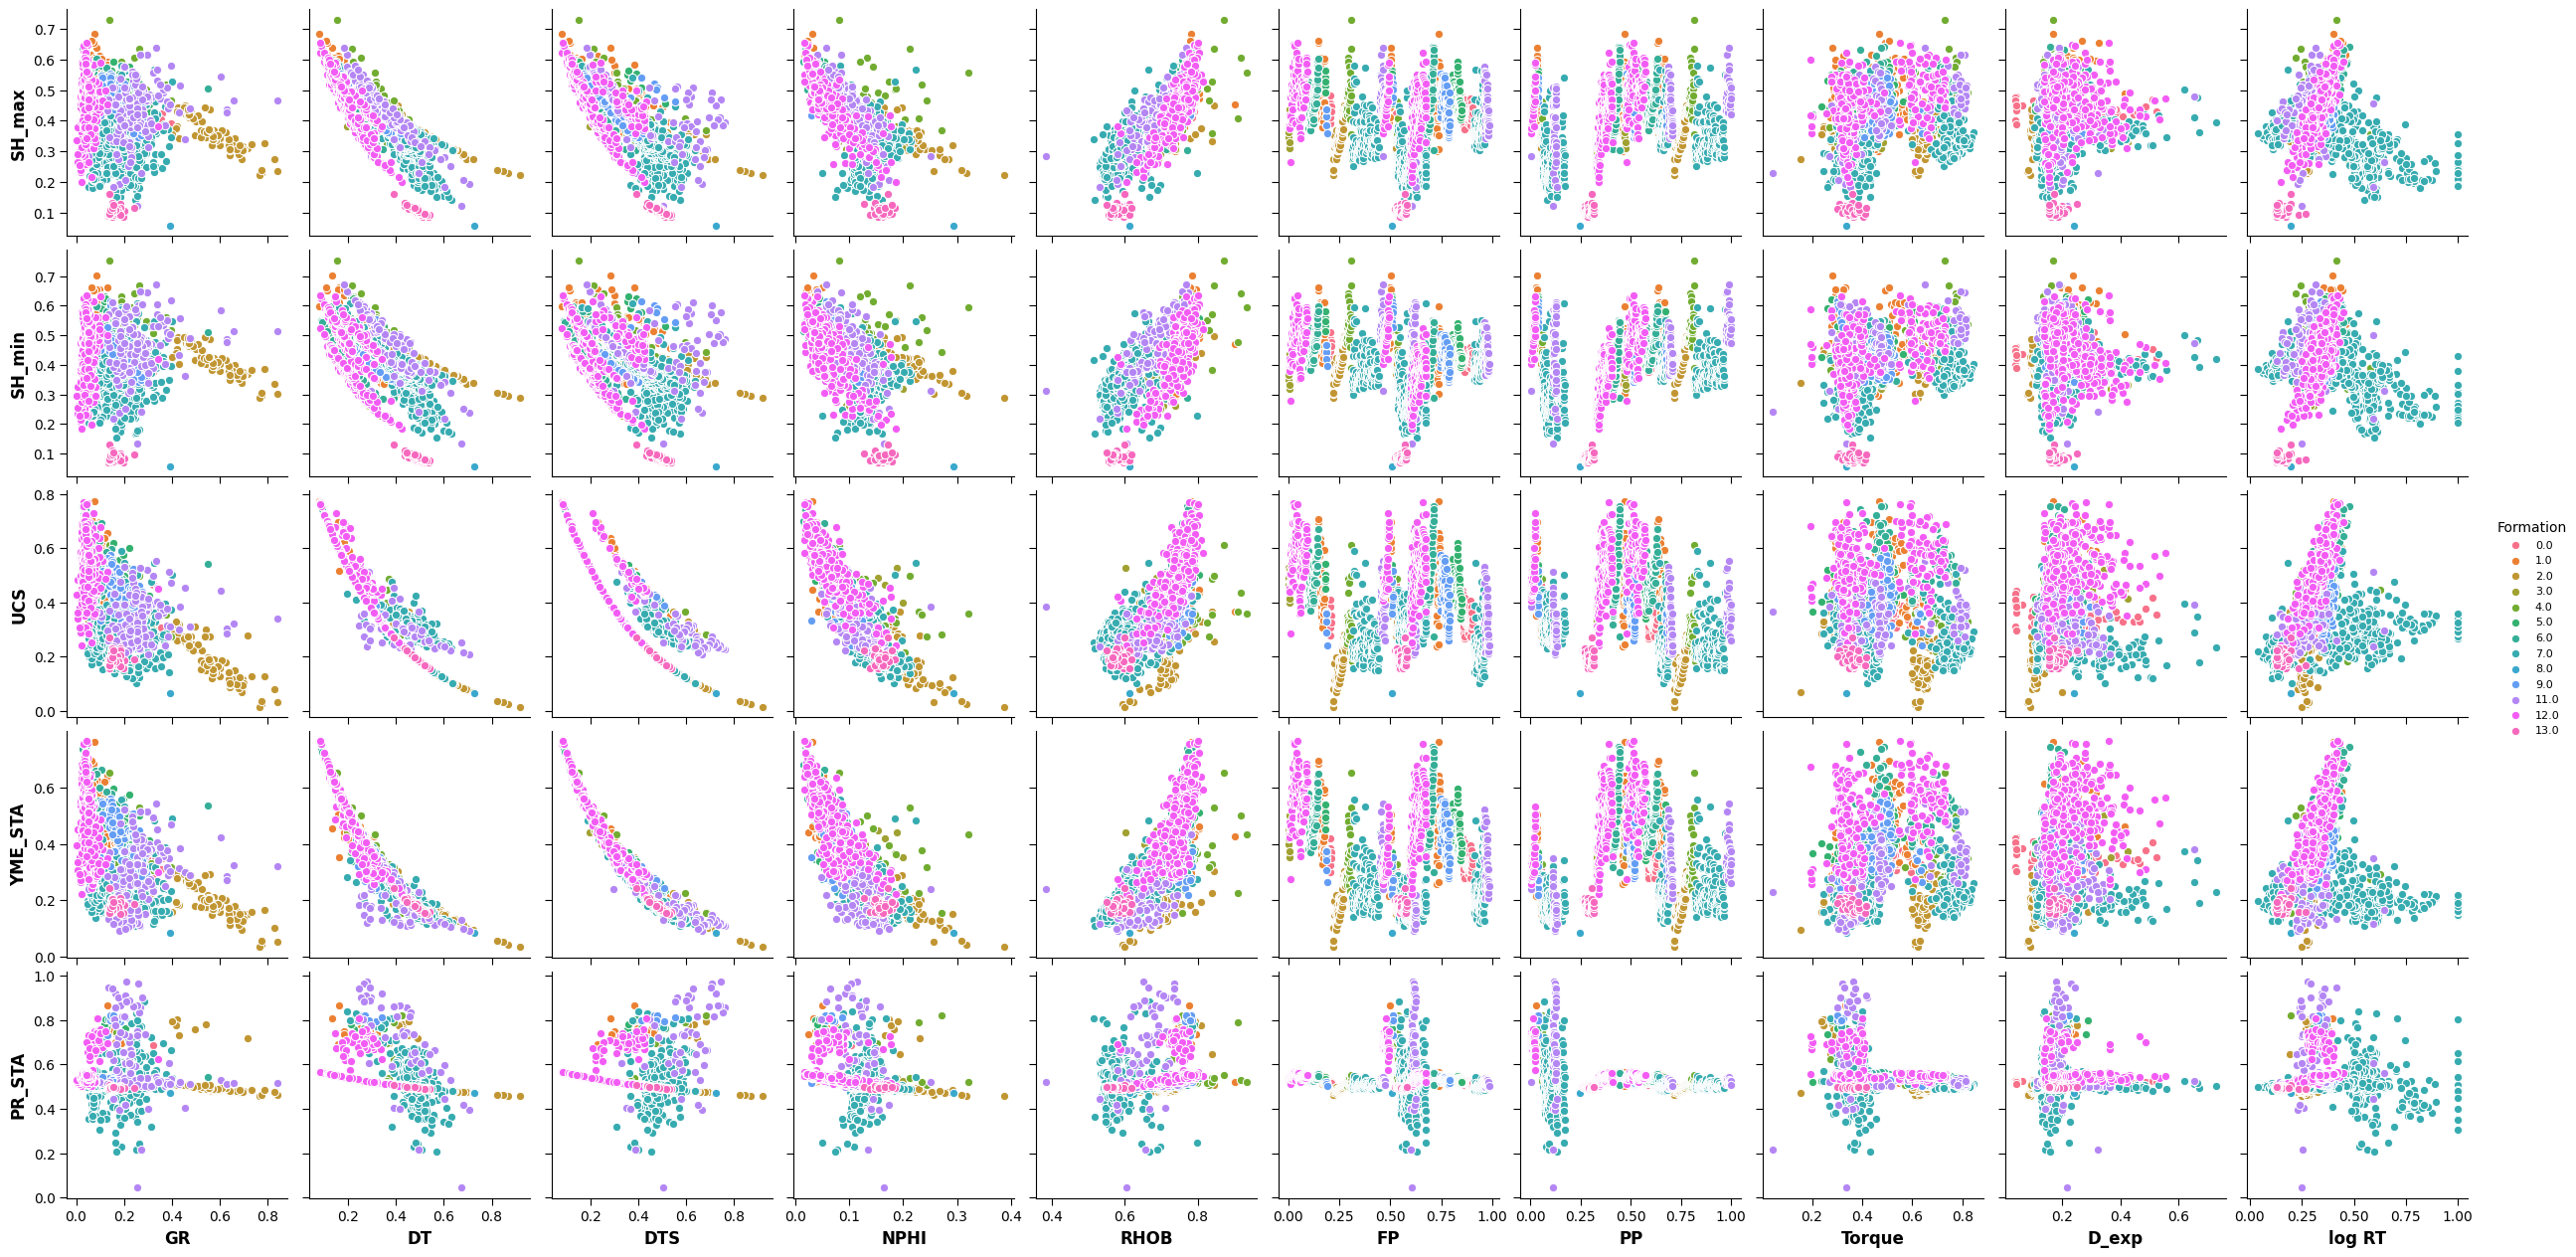

In [60]:
Multi_crossplot(data=train_svm, 
                x=['GR', 'DT', 'DTS', 'NPHI', 'RHOB', 'FP', 'PP', 'Torque', 'D_exp', 'log RT'],
                y=['SH_max', 'SH_min', 'UCS', 'YME_STA', 'PR_STA'], 
                color='Formation')

There is indeed a slight improvement that is noticible in the graphs.
Now let's split the data and fit the model, below a single exmple for GradientBoostingRegressor combined with MultiOutputRegressor since we want to have multiple outputs.

# 4. Model Building, Fitting and Tunning

In [63]:
# Let's split the data to a 80/20 ratio, traning/testing 
train_df=train_iso[['MD', 'GR', 'DT', 'DTS', 'NPHI', 'RHOB', 'log RT']]
y=train_iso[['SH_max', 'SH_min', 'UCS', 'YME_STA', 'PR_STA']]
X_train, X_test, Y_train, Y_test = train_test_split(train_df, y, test_size=0.2, random_state=42)


# Initialize the model with default values
estimator =  MultiOutputRegressor(GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=300, subsample=1.0,
                                                            criterion='friedman_mse', min_samples_split=4,
                                                            min_samples_leaf=2,
                                                            min_weight_fraction_leaf=0.0, max_depth=3,
                                                            min_impurity_decrease=0.0,
                                                            min_impurity_split=None, init=None, random_state=None,
                                                            max_features=None,
                                                            alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False,
                                                            validation_fraction=0.1, n_iter_no_change=None, tol=0.0001,
                                                            ccp_alpha=0.0))

# Set a dec includes all the hyperparameters that we wanna test
# Note that hyperparameters are unique to the model it self, so other models will differ
hyperparameters = dict(estimator__learning_rate=[0.05, 0.2], estimator__loss=['lad', 'huber'],
                     estimator__n_estimators=[50, 200],
                     estimator__criterion=['friedman_mse', 'mse'], estimator__min_samples_split=[2, 7],
                     estimator__max_depth=[3, 5, 10, 15, 20, 30], estimator__min_samples_leaf=[1, 2, 3, 5, 8, 10],
                     estimator__min_impurity_decrease=[0, 0.2, 0.4, 0.6, 0.8],
                     estimator__max_leaf_nodes=[5, 10, 20, 30, 50, 100, 300])

randomized_search = RandomizedSearchCV(model, hyperparameters, random_state=0, n_iter=5, scoring=None,
                                       n_jobs=2, refit=True, cv=5, verbose=True,
                                       pre_dispatch='2*n_jobs', error_score='raise', return_train_score=True)

# Random search tries various combinations of the hyperparameters,
# If you have more computing power, you can try the grid search.
hyperparameters_tuning = randomized_search.fit(x, y)
estimator.fit(X_train,Y_train)


print('Train set mse:', mean_squared_error(Y_train, estimator.predict(X_train)))
print('Test set mse:', mean_squared_error(Y_test, estimator.predict(X_test)))
print('Test set R_2:', r2_score(Y_test, estimator.predict(X_test)))

Train set mse: 3.069116783640482e-05
Test set mse: 5.0382786755747756e-05
Test set R_2: 0.9888094201916647


The results seem decent for reference:
- **MSE** is used to check how close estimates or forecasts are to actual values. Lower the MSE, the closer is forecast to actual. This is used as a model evaluation measure for regression models and the lower value indicates a better fit.

- **R-2** is a statistical measure that represents the goodness of fit of a regression model. The ideal value for r-square is 1. The closer the value of r-square to 1, the better is the model fitted.

# 5. Model Blind Test

Now in order to assess the model, let's a well that is not included in the training data, to see how the model actually performes.

In [79]:
# Lets test and visualize on a blind well
Test_well=pd.read_csv('Blind well example.csv')

# Scaling the parameters
features_test= min_max_scaler_features.fit_transform(Test_well[['MD', 'GR', 'DT', 'DTS', 'NPHI', 'RHOB', 'log RT']])
Target_test= Test_well[['SH_max', 'SH_min', 'UCS', 'YME_STA', 'PR_STA']]

# Predicting the output
Model_predection=estimator.predict(features_test)
df_Model_predection=pd.DataFrame(min_max_scaler_target.inverse_transform(Model_predection), columns=['Mod_SH_max', 'Mod_SH_min', 'Mod_UCS', 'Mod_YME_STA', 'Mod_PR_STA'])

# Joining the entity of the data
real_predict_data=Test_well.join(df_Model_predection)
real_predict_data=real_predict_data.drop('Unnamed: 0', axis=1)

Let's build a log like visual to compare the data:
- *Black*: represents the actual data from the blind well.
- *Red*: represents the model prediction.

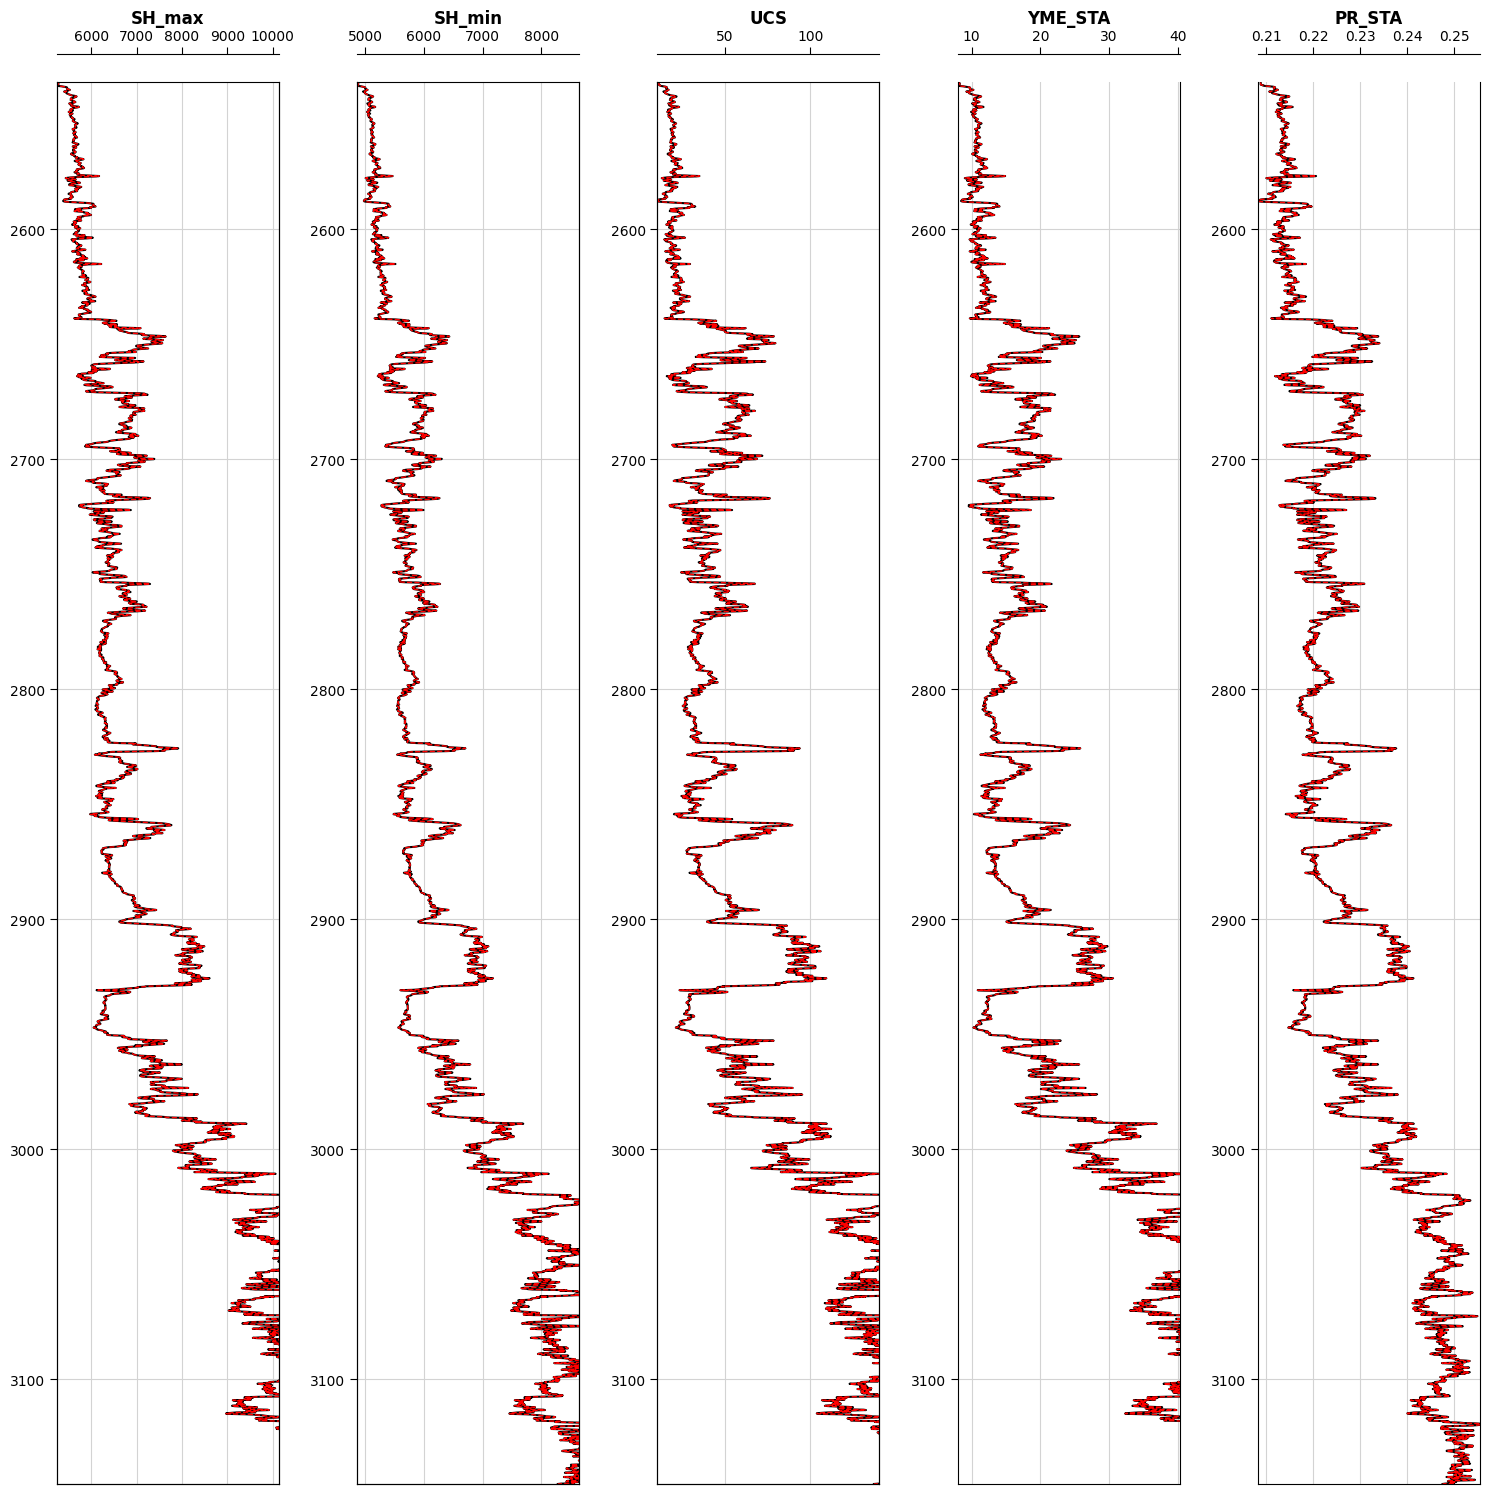

In [92]:
df_y_test1=real_predict_data.copy()
df_y_test1=df_y_test1[:4000]

# Custom function for combo log plotting
Log_vis(df_y_test1,sh_ind='MD', num_subplot=5, size=(15,15),
        combos=[['SH_max','Mod_SH_max'],['SH_min','Mod_SH_min'],['UCS','Mod_UCS']
                ,['YME_STA','Mod_YME_STA'],['PR_STA','Mod_PR_STA']], 
        style=['line','dashed'], color=['black', 'red'], min_max_limite=True, indicator=True)

# 6. Final Notes

- Machine learning, like any other powerful tool, requires extensive processing. It is not a **magic box** into which you simply input data and predict. Extensive research and testing is required to get an effective model ready for deployment.
- The model is very data-sensitive, which means two things: bad data leads to a bad model, regardless of the model used (**Better Data, Better Results**), and secondly, it is limited to the range of your data (**Bias**), so **you can't!** take a model trained in a specific region and deploy it elsewhere.
- This Notebook is only a general framework for regression, it will change considerably in other applications and with different types and shapes of data.

---
### Badr Eddine Berrehal (Petroleum Engineer & Data Analyst)
- **Email:** [berrehalbadr@gmail.com](berrehalbadr@gmail.com)
- **LinkedIn:** [Badr Berrehal](https://www.linkedin.com/in/badreddine-berrehal-a51010175)
- **Personal Web site:** [UDATA](https://sites.google.com/view/badreddine-berrehal/accueil)
- **GitHub:** [berrehalbadr](https://github.com/berrehalbadr)
- **License Type:** MIT license